# Loading packages

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import os
import scipy
from scipy.stats import shapiro, ttest_1samp, ttest_ind, ttest_rel, f, bartlett, levene
from scipy.optimize import minimize
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import datetime
import time
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import copy
from tabulate import tabulate

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (50,10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

# Chapter 1
# Introduction
Code for the Introduction, with explorative analysis and the definitions of temp+ and temp-

# Loading the dataset

In [2]:
# loading the dataset
data = pd.read_excel('Thesis_Dataset.xlsx', sheet_name=None, index_col=0)

In [3]:
# Making a copy of the dataset since the loading takes some time
data_edit = copy.deepcopy(data)

# Select a store
to use as main example. To see the results for other stores, change the value in the following cell.

In [4]:
città = 'store_24' #this store is different from the one in used in the thesis so we can show different figures

datacittà = data_edit[città].dropna()

# Here we see the dataset for the store selected

In [5]:
datacittà

,date,year,month,week,y_day,m_day,w_day,hour,kWh,m3,cust,emp,temp,M_temp,m_temp,season,error,led,pvp,BMS
2016-01-01 00:00:00,2016-01-01,2016,1,0,1,1,5,0,31.2,8680,0.0,0.0,14.0,17.0,10.0,inv,0,0.0,0,0
2016-01-01 01:00:00,2016-01-01,2016,1,0,1,1,5,1,29.4,8680,0.0,0.0,14.0,17.0,10.0,inv,0,0.0,0,0
2016-01-01 02:00:00,2016-01-01,2016,1,0,1,1,5,2,27.6,8680,0.0,0.0,14.0,17.0,10.0,inv,0,0.0,0,0
2016-01-01 03:00:00,2016-01-01,2016,1,0,1,1,5,3,25.5,8680,0.0,0.0,14.0,17.0,10.0,inv,0,0.0,0,0
2016-01-01 04:00:00,2016-01-01,2016,1,0,1,1,5,4,26.4,8680,0.0,0.0,14.0,17.0,10.0,inv,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019-12-31,2019,12,52,365,31,2,19,66.6,8680,1.0,1.0,7.2,14.0,2.0,inv,0,1.0,0,1
2019-12-31 20:00:00,2019-12-31,2019,12,52,365,31,2,20,63.0,8680,0.5,1.0,7.2,14.0,2.0,inv,0,1.0,0,1
2019-12-31 21:00:00,2019-12-31,2019,12,52,365,31,2,21,55.8,8680,0.0,0.0,7.2,14.0,2.0,inv,0,1.0,0,1
2019-12-31 22:00:00,2019-12-31,2019,12,52,365,31,2,22,53.4,8680,0.0,0.0,7.2,14.0,2.0,inv,0,1.0,0,1


# Some figures to better understand the data

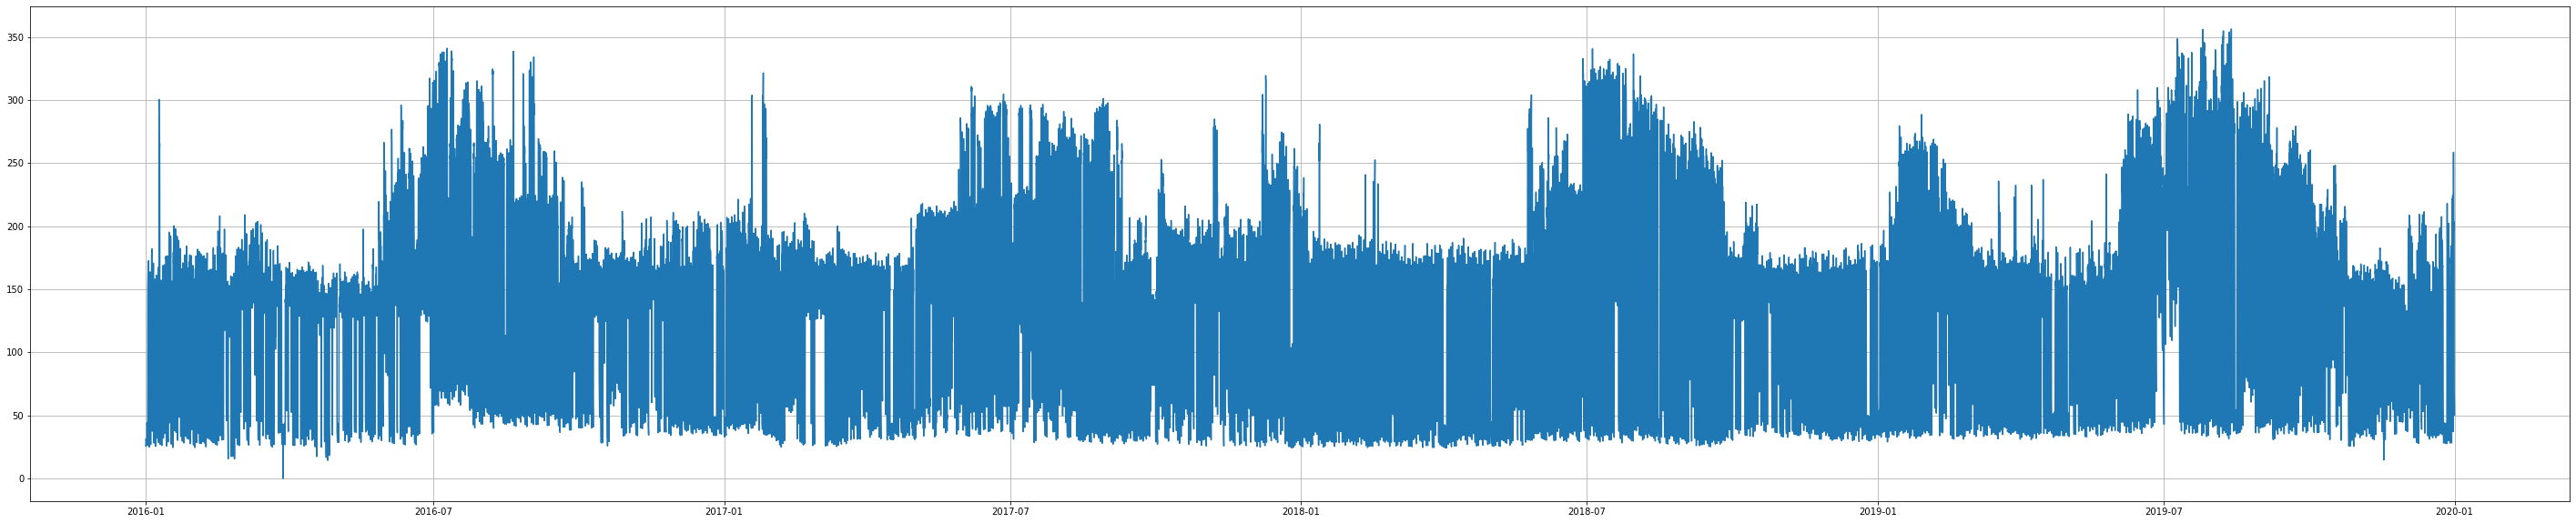

In [6]:
#The consumes in kWh

plt.plot(datacittà['kWh'])
plt.show()

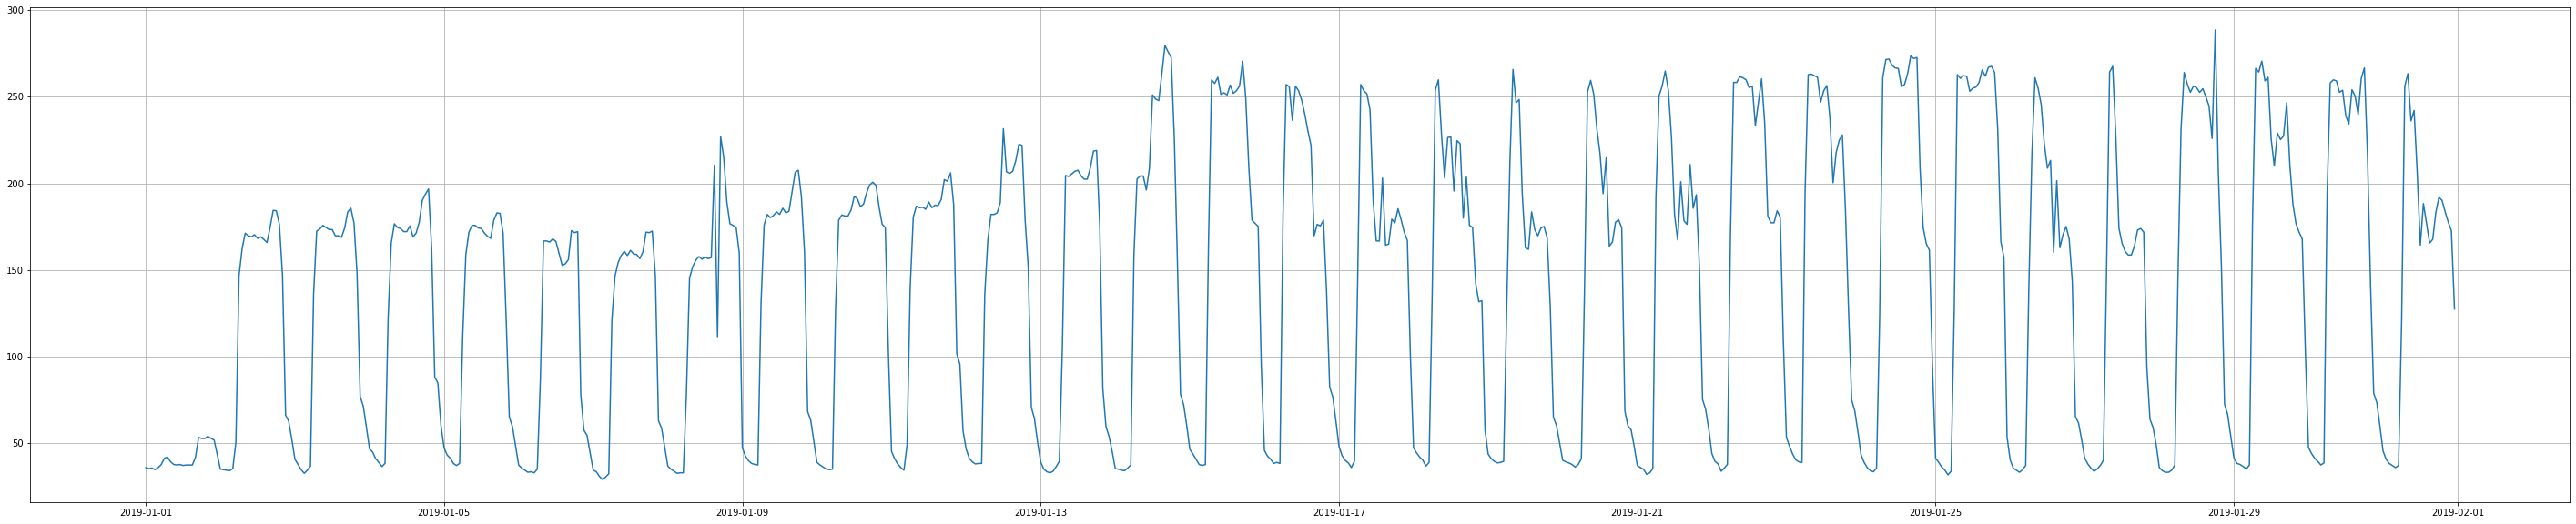

In [7]:
# Zoom on the consumes (example of January 2019)
mask1 = datacittà['year']==2019
mask2 = datacittà['month']==1
plt.plot(datacittà[(mask1) & (mask2)]['kWh'])
plt.show()

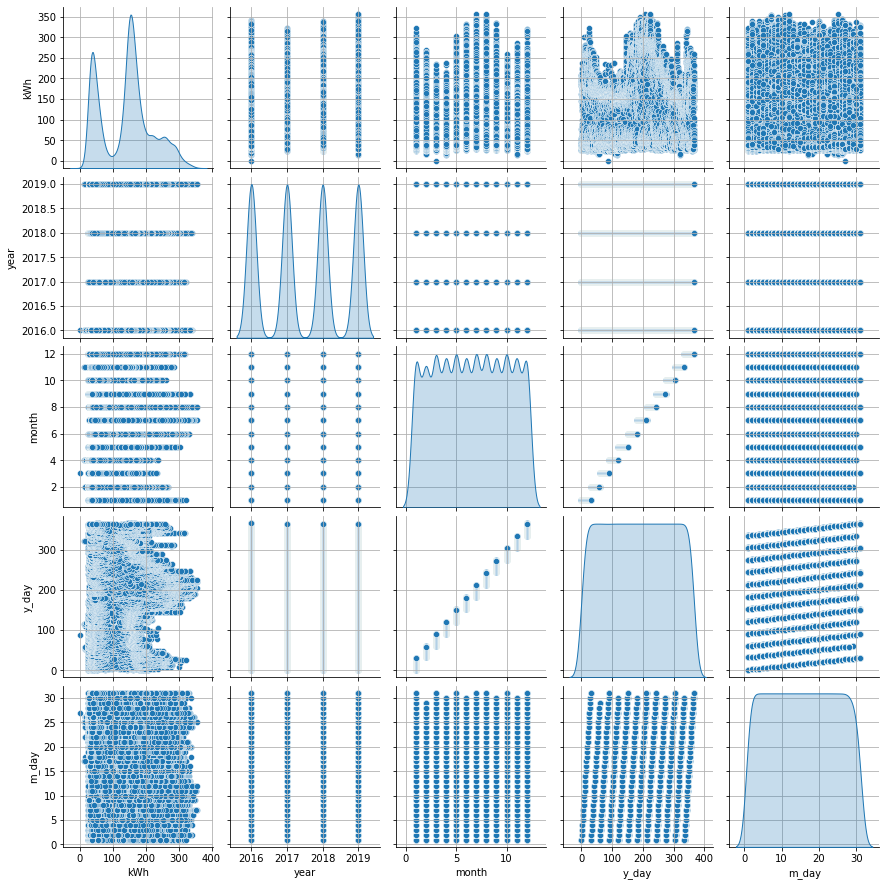

In [8]:
# scatterplot for the consumes and the datetime variables

sns.pairplot(datacittà[['kWh', 'year', 'month', 'y_day', 'm_day']], diag_kind="kde")

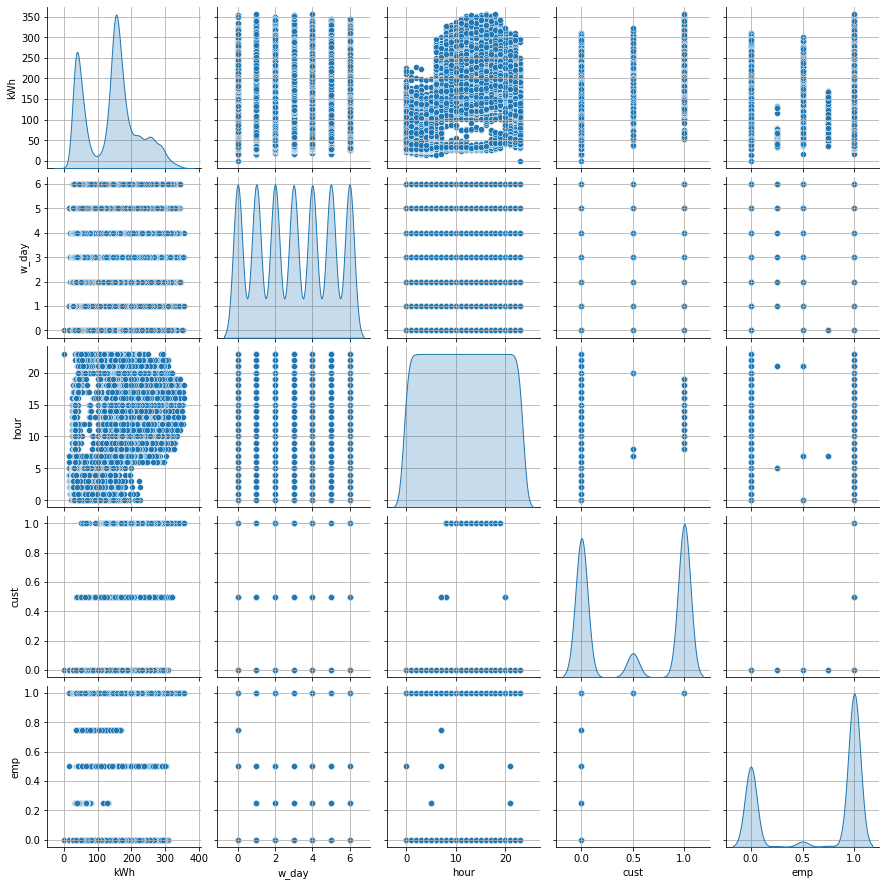

In [9]:
# scatterplot for the consumes, other datetime variables and the presence of customers and emplyees

sns.pairplot(datacittà[['kWh', 'w_day', 'hour', 'cust', 'emp']], diag_kind="kde")

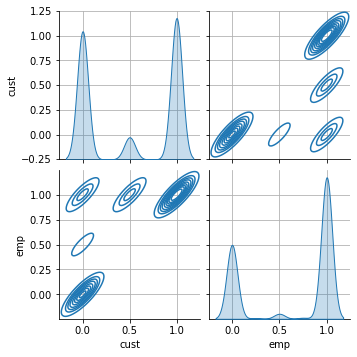

In [10]:
# Saving the picture of the scatter plot of cust and emp for the thesis

sns.pairplot(datacittà[['cust', 'emp']], kind="kde")
plt.savefig('cust_dip.png')

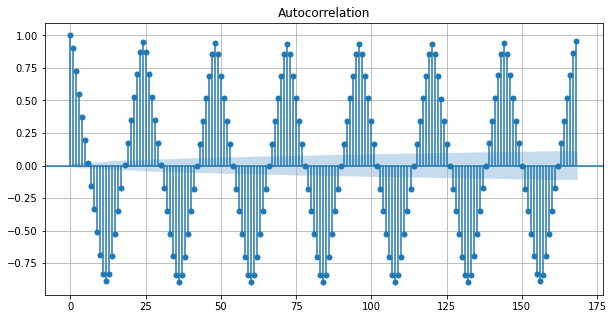

In [11]:
# Saving a picture of the ACF of cust

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(data_edit[città]['cust'].dropna(), ax = ax, lags=24*7)
fig.savefig('cust_acf.png')
plt.show()

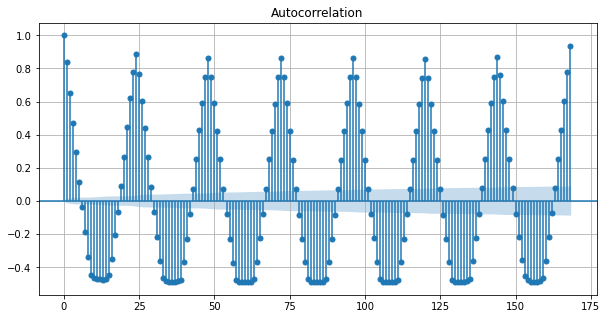

In [12]:
# Saving a picture of the ACF of emp

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(data_edit[città]['emp'].dropna(), ax = ax, lags=24*7)
fig.savefig('emp_acf.png')
plt.show()

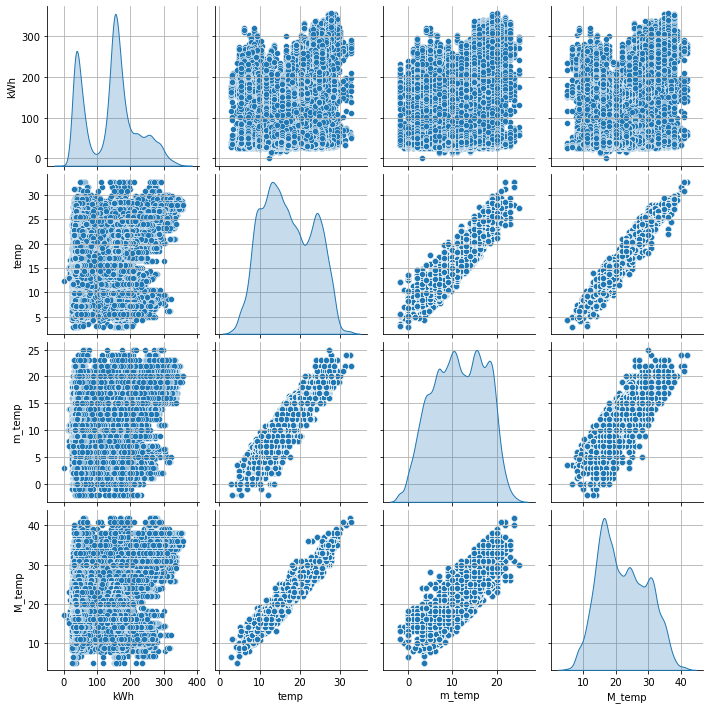

In [13]:
# Scatter plot for the consumes and the temperatures data

sns.pairplot(datacittà[['kWh', 'temp', 'm_temp', 'M_temp']], diag_kind="kde")

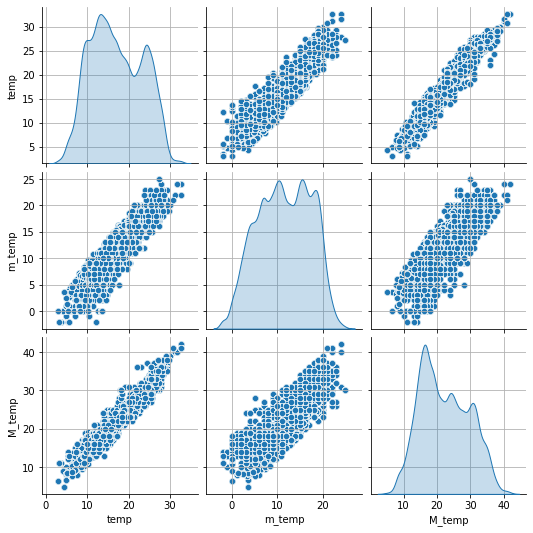

In [14]:
# Saving a picture of the scatter plot for the temperatures

sns.pairplot(datacittà[['temp', 'm_temp', 'M_temp']], diag_kind="kde")
plt.savefig('temps.png')

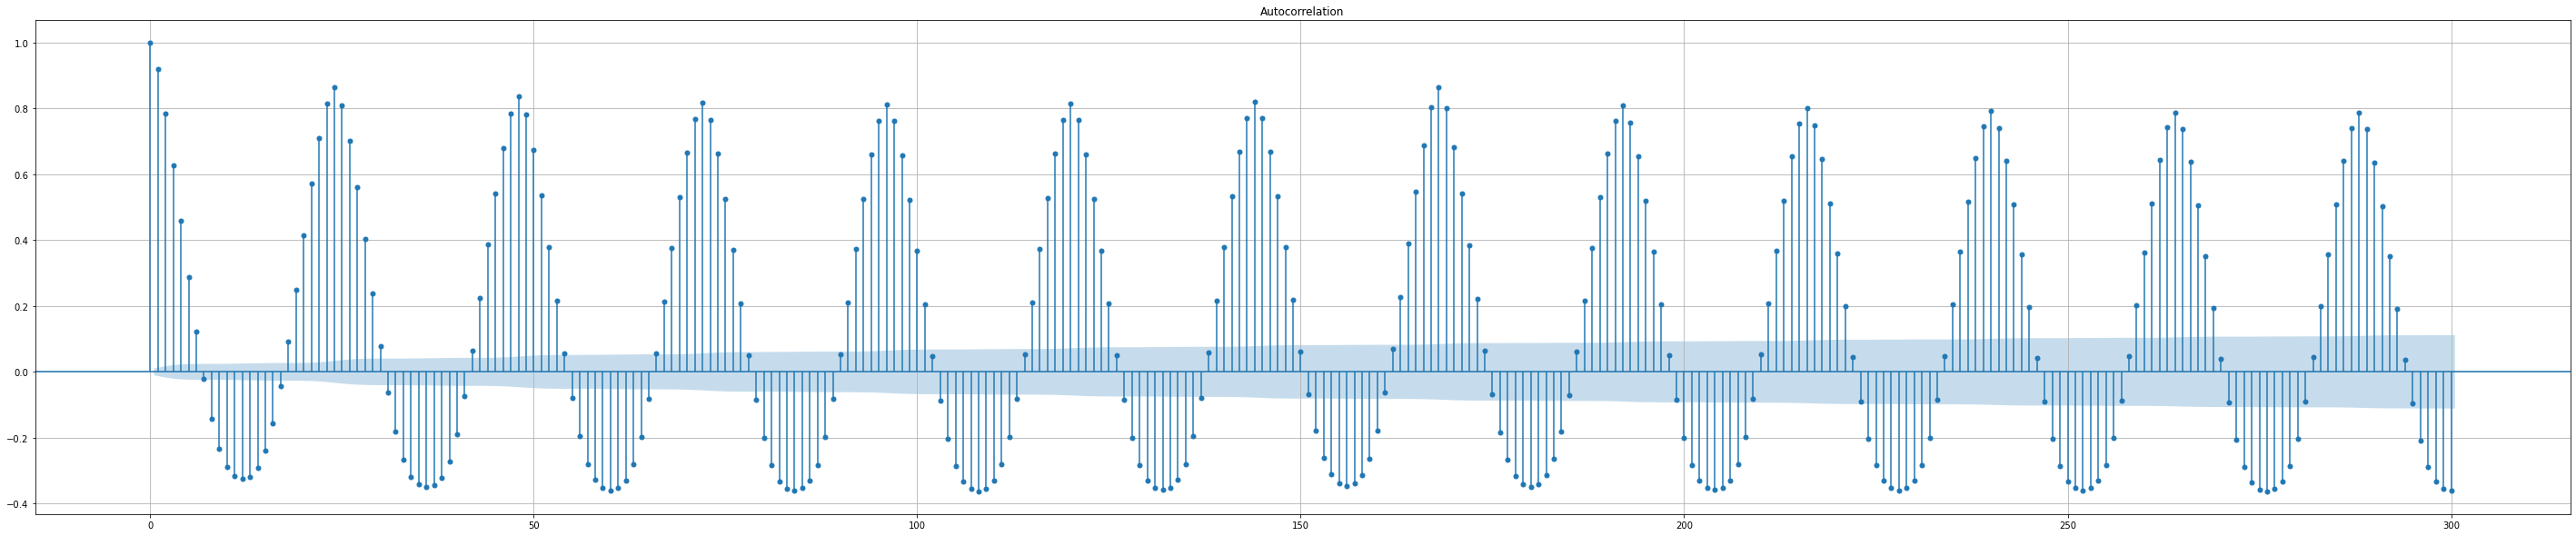

In [15]:
# ACF of the consumes

sm.graphics.tsa.plot_acf(datacittà['kWh'].dropna(), lags=300)
plt.show()

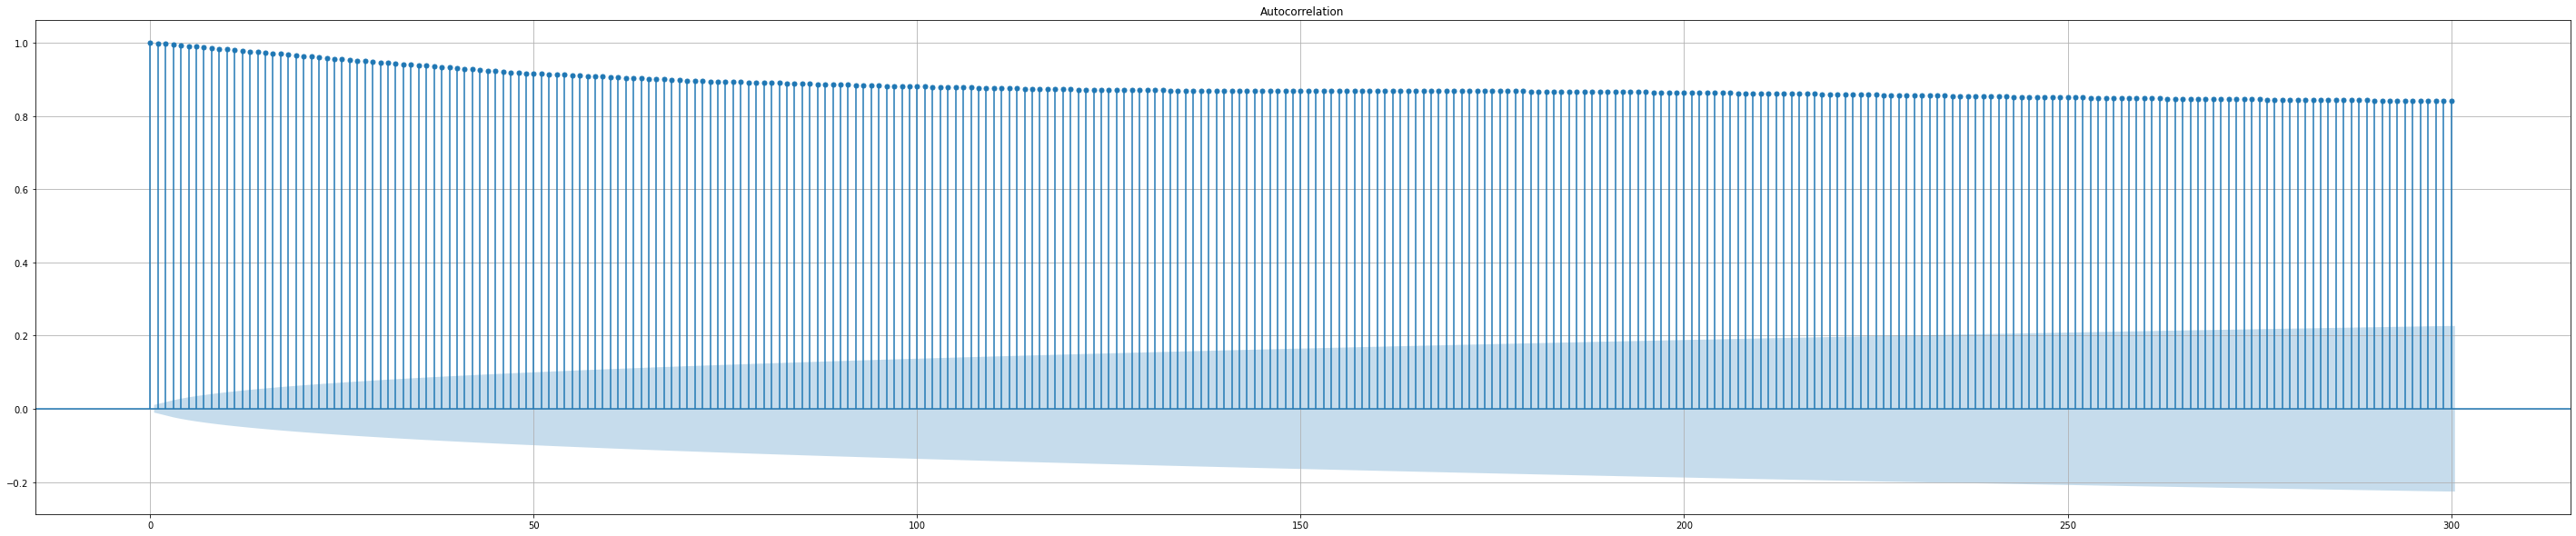

In [16]:
# ACF of temp

sm.graphics.tsa.plot_acf(datacittà['temp'].dropna(), lags=300)
plt.show()

# Studying the effect of temp on the consumes

In [17]:
# here I collect all the temperatures registerd for the store (without duplicates)
temp_list = np.sort(datacittà.dropna()['temp'].unique())

# here I collect the maximum of the consumes for each temperature (remember that the temperature stays the same for each whole day)
cons_list = []
for temp in np.sort(temp_list):
    cons = np.nanmax(datacittà[datacittà['temp'] == temp]['kWh'])
    cons_list.append(cons)

In [18]:
# here we build a ball of influencial observation for the Savitzky-Golay filter (SG filter)
ball = np.round(int(np.sqrt(len(cons_list))))
if ball%2 !=1:
    ball = ball+1
ball = int(ball)

# here we apply the SG filter on the maximum consumes collected above, with the "ball" just built and with a polynomial of degree 1
poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

# Save the values for t0 and c0 as defined in the thesis
t0 = np.sort(datacittà['temp'].unique())[np.argmin(poly_y)]
c0 = min(poly_y)

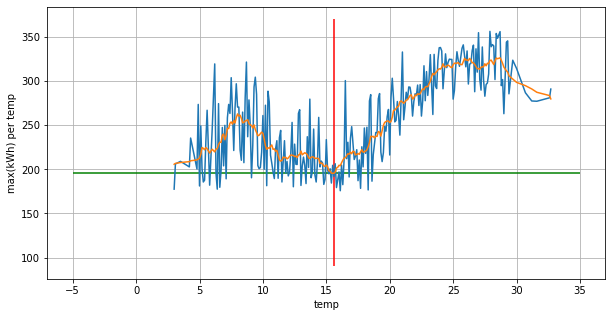

In [19]:
# Saving and plotting the results of the SG filter
# in blu there are the maximum consumes per temperature
# in orange the filtered consumes
# in red t0
# in green c0

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(temp_list, cons_list)
ax.plot(temp_list, poly_y)

ax.vlines(t0, 90,370, colors='red')
ax.hlines(c0, -5, 35, colors='green')
plt.xlabel('temp')
plt.ylabel('max(kWh) per temp')
fig.savefig('SG_filter.png')
plt.show()

# Adding temp+ and temp-
according to the definition given in the thesis.
Temp is split in the 2 new variables and then we subtracted t0 and set =0 the negative values, like in a ReLU.
We also eliminate the effect of the temperature on observations with consumes lower than c0.

In [20]:
# Creating the 2 new variables with center in t0
datacittà['temp+'] = datacittà['temp']-t0
datacittà['temp-'] = t0 - datacittà['temp']

# creating the mask for the observations with temp+/- to be set =0
maskt0p = datacittà['temp+']<0
maskt0n = datacittà['temp-']<0
maskc0 = datacittà['kWh']<c0

# setting the =0s
datacittà.loc[maskt0p, 'temp+']=0
datacittà.loc[maskt0n, 'temp-']=0
datacittà.loc[maskc0, 'temp+']=0
datacittà.loc[maskc0, 'temp-']=0

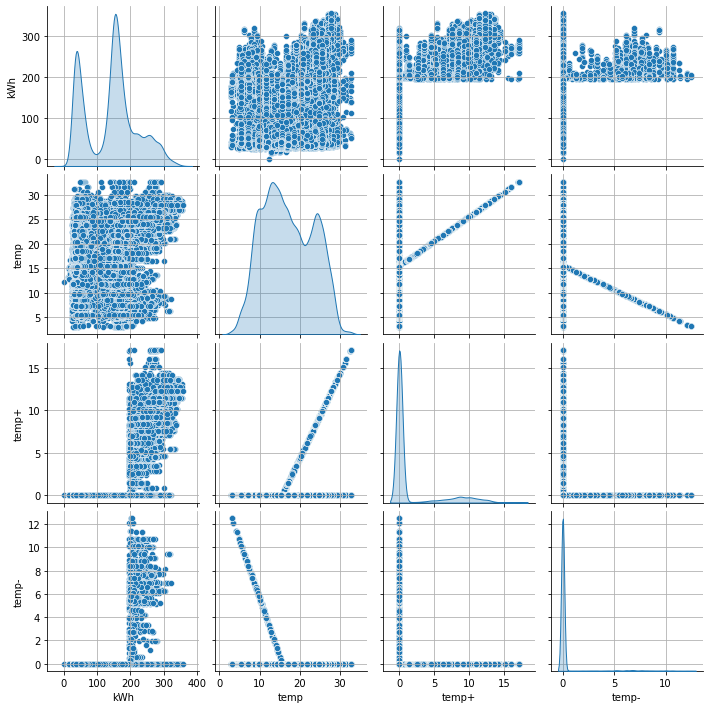

In [21]:
# Saving the scatter plot for the consumes, temp, temp+ and temp-

sns.pairplot(datacittà[['kWh', 'temp', 'temp+', 'temp-']], diag_kind="kde")
plt.savefig('kWh_vs_temps.png')

# Creating temp+ and temp- for all the stores

In [22]:
# same procedure seen above, this time inside a "for cycle" to set the variables for all the stores in the complete dataset
for store in data_edit:
    temp_list = np.sort(data_edit[store].dropna()['temp'].unique())
    cons_list = []
    for temp in np.sort(temp_list):
        cons = np.nanmax(data_edit[store][data_edit[store]['temp'] == temp]['kWh'])
        cons_list.append(cons)
        
    ball = np.round(int(np.sqrt(len(cons_list))))
    if ball%2 !=1:
        ball = ball+1
    ball = int(ball)
    poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

    t0 = np.sort(data_edit[store]['temp'].unique())[np.argmin(poly_y)]
    c0 = min(poly_y)
    
    data_edit[store]['temp+'] = data_edit[store]['temp']-t0
    data_edit[store]['temp-'] = t0 - data_edit[store]['temp']

    maskt0p = data_edit[store]['temp+']<0
    maskt0n = data_edit[store]['temp-']<0
    maskc0 = data_edit[store]['kWh']<c0

    data_edit[store].loc[maskt0p, 'temp+']=0
    data_edit[store].loc[maskt0n, 'temp-']=0
    data_edit[store].loc[maskc0, 'temp+']=0
    data_edit[store].loc[maskc0, 'temp-']=0

# Chapter 2
# Models for explorative analysis
Here we see the code for creating the models presented in this chapter

# OLS

Model for the store selected at the beginning 

In [23]:
# setting the variables we want as X to build our model on them
X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']

# removing the variables from X that remains constant in the whole store dataset since they don't bring information
X1 = []
for x in X:
    if len(datacittà[x].unique()) > 1:
        X1.append(x)

In [24]:
# create x and y on which to build the model
# y is kept as the original observations in kWh
x = datacittà[X1]
y = datacittà['kWh']

# adding the intercept to x
x = sm.add_constant(x)

# building the model thanks to the OLS function in statsmodels
model = sm.OLS(y,x)
results = model.fit()

# print the summary
print(città, '\n', results.summary(), '\n\n')

# defining the fitted values for y
yhat = results.fittedvalues

store_24 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                 2.500e+04
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:55:47   Log-Likelihood:            -1.7059e+05
No. Observations:               35061   AIC:                         3.412e+05
Df Residuals:                   35053   BIC:                         3.413e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.9374      0.318    191.5

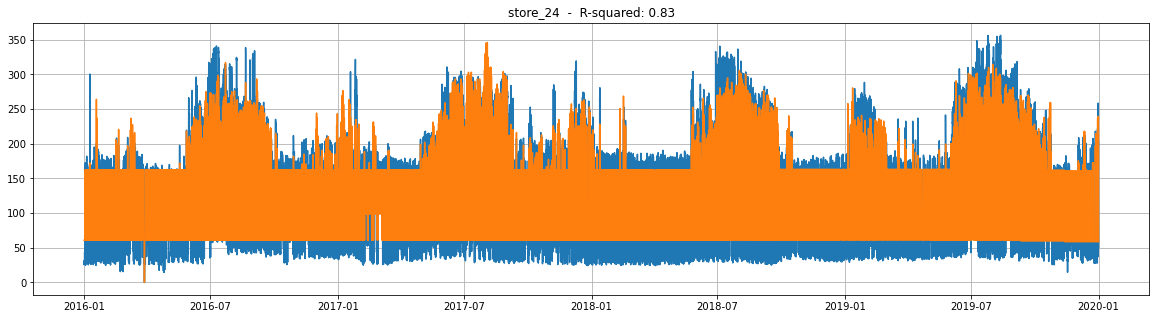

In [25]:
# Saving the picture of y and yhat

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
plt.title('{}  -  R-squared: {}'.format(città, np.round(results.rsquared,2)))
fig.savefig('OLS_plot.png')
plt.show()

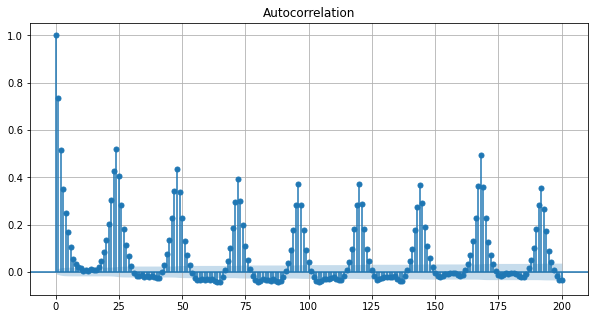

In [26]:
# Saving the ACF of the residuals of the model

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('OLS_acf.png')
plt.show()

Models for all the stores

In [27]:
# saving some metrics to evaluate the models
R2 = []
mse = []
expl_var = []

# same process as above, this time for all the models
for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    x = data_edit[store].dropna()[X1]
    y = data_edit[store].dropna()['kWh']

    x = sm.add_constant(x)

    model = sm.OLS(y,x)
    results = model.fit()
    
    
    # saving the values for the metrics
    R2.append(results.rsquared)
    mse.append(mean_squared_error(y, results.fittedvalues))
    expl_var.append(explained_variance_score(y, results.fittedvalues))

# printing the median for the metrics
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8401949041336612 886.6229211431717 0.8401949041336613


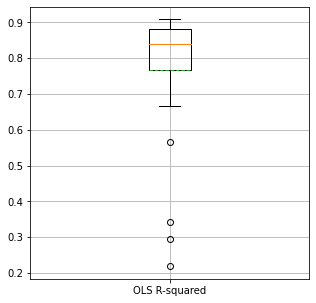

In [28]:
# Saving a boxplot of the R-squared obtained

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['OLS R-squared'], meanline=True, showmeans=True)
fig.savefig('OLS_boxplot.png')
plt.show()

OLS model with transformations of y

store_24 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 1.896e+04
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:55:53   Log-Likelihood:                -11467.
No. Observations:               35061   AIC:                         2.295e+04
Df Residuals:                   35054   BIC:                         2.301e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9768      0.003   1169.4

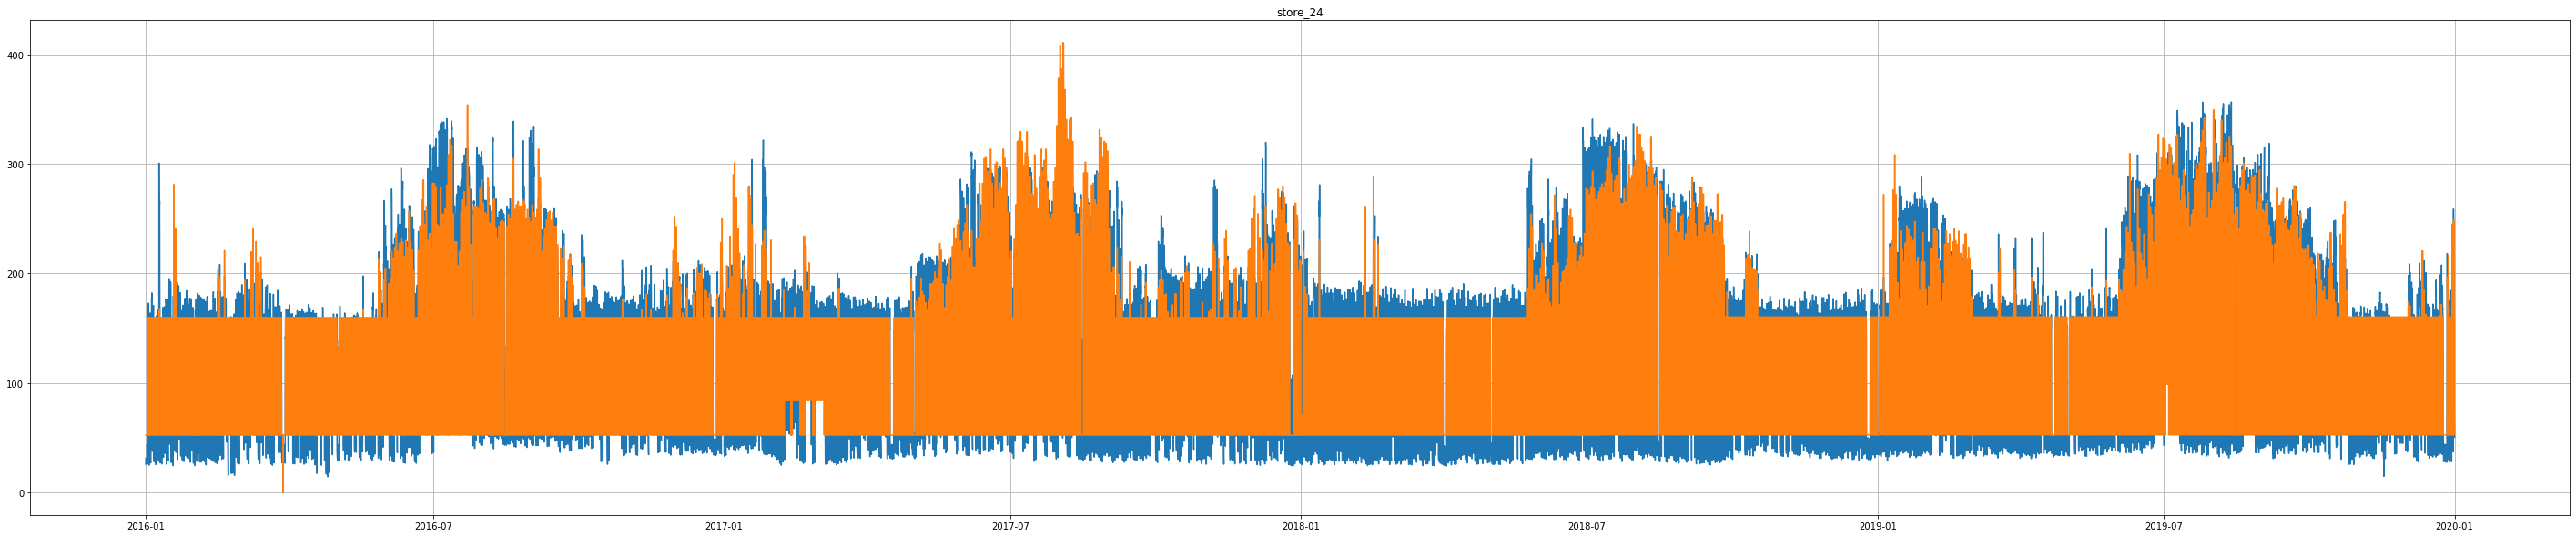

In [29]:
# as above, but this time y = log(1+ kWh)
x = datacittà[X1]
y = np.log(1 + datacittà['kWh'])

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(città, '\n', results.summary(), '\n\n')

yhat = results.fittedvalues

plt.plot(np.exp(y)-1)
plt.plot(np.exp(yhat)-1)
plt.title('{}'.format(città))
plt.show()

store_24 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 2.410e+04
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:55:54   Log-Likelihood:                -64992.
No. Observations:               35061   AIC:                         1.300e+05
Df Residuals:                   35054   BIC:                         1.301e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4973      0.016    479.0

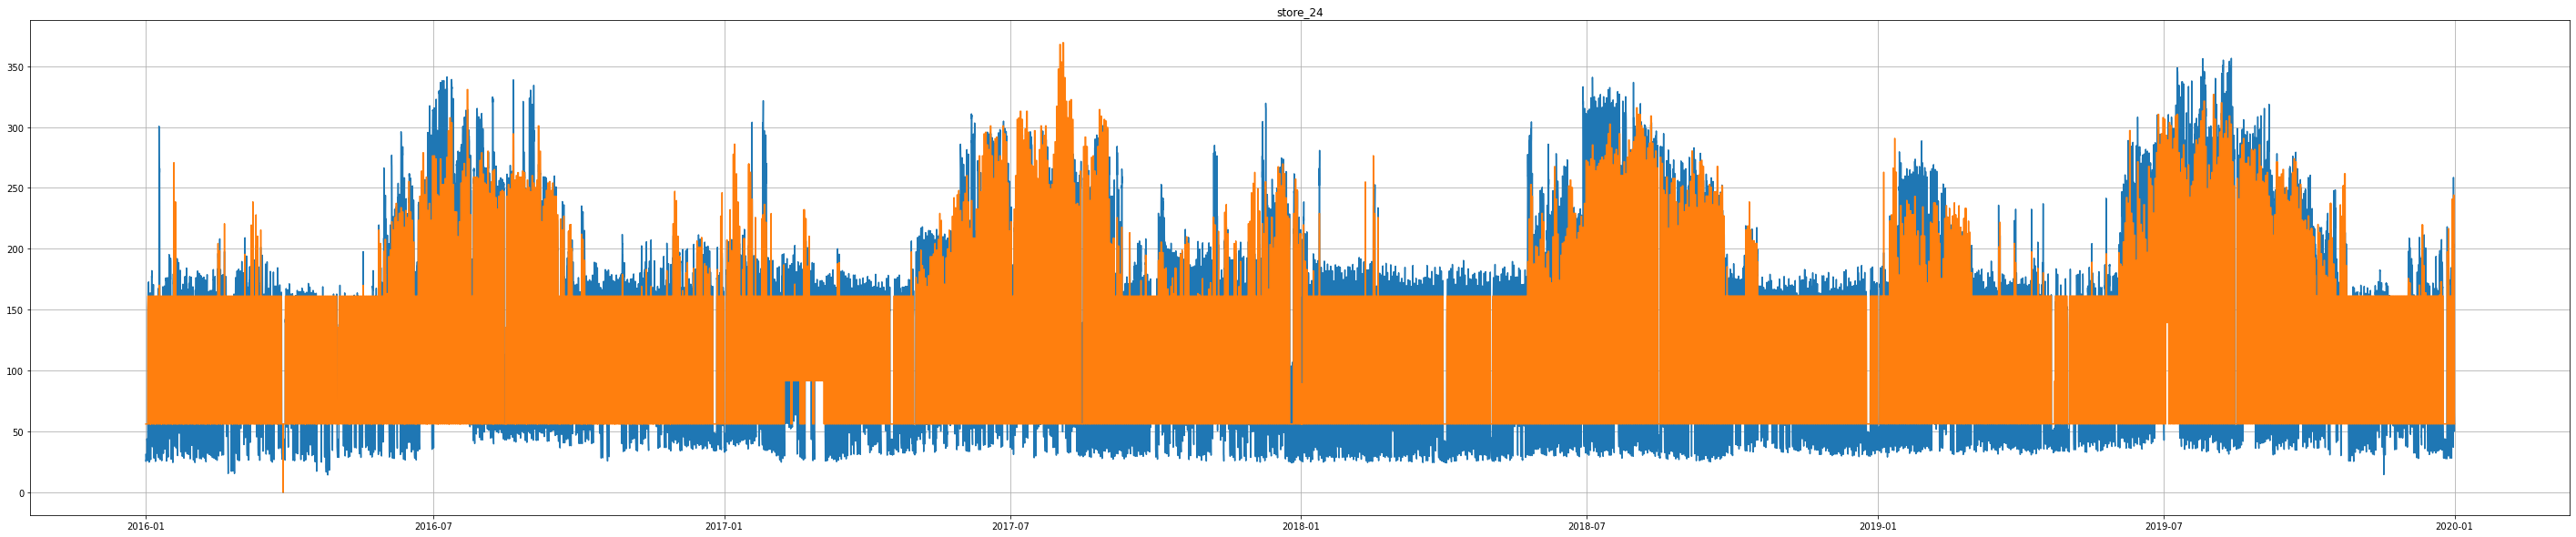

In [30]:
# as above, but this time y = sqrt(kWh)
x = datacittà[X1]
y = np.sqrt(datacittà['kWh'])

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(città, '\n', results.summary(), '\n\n')

yhat = results.fittedvalues

plt.plot(y**2)
plt.plot(yhat**2)
plt.title('{}'.format(città))
plt.show()

# NNLS (Non Negative Least Square)

In [31]:
# This time we just show the results for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    x = data_edit[store].dropna()[X1]
    y = data_edit[store].dropna()['kWh']

    x = sm.add_constant(x)
    
    # the model is built thanks to the command nnls in scipy
    coef, res = scipy.optimize.nnls(x, y)
    yhat = x.dot(coef)
    
    R2.append(r2_score(y, yhat))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8385766518467574 904.0848257661919 0.8385766518467573


# Decision Tree

In [32]:
# 5-fold Cross Validation to select the best value for the maximum number of leaves of thr DT

num_leaves = range(10,100,10)
scores = []
for i in num_leaves:
    i_scores = []
    for store in data_edit:
        X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
        X1 = []
        for x in X:
            if len(data_edit[store].dropna()[x].unique()) > 1:
                X1.append(x)
    
        
        x = data_edit[store].dropna()[X1]
        y = data_edit[store].dropna()['kWh']
        
        model = DecisionTreeRegressor(max_leaf_nodes = i)
        città_scores = cross_val_score(model, x, y, scoring='r2', cv=5)
        città_score = np.nanmean(città_scores)
        i_scores.append(città_score)
    i_score = np.nanmean(i_scores)
    scores.append(i_score)
    
mln = num_leaves[np.argmax(scores)]
print(mln)

30


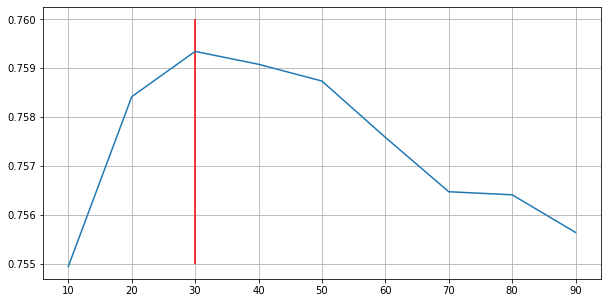

In [33]:
# Saving a picture of the R-squareds scored in the 5-fold CV
# The red line is the maximum value

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(num_leaves, scores)
ax.vlines(mln, 0.755, 0.76, color='red')
fig.savefig('DT_kfCV.png')
plt.show()

In [34]:
# setting the varaibles in X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []
for x in X:
    if len(datacittà.dropna()[x].unique()) > 1:
        X1.append(x)

# finding the time of the first intervention to split the dataset in training/test sets
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# x, y -> training set
# x1,y1 -> test set
x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# building the model thanks to the command in sklearn
model = DecisionTreeRegressor(max_leaf_nodes = mln) 
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

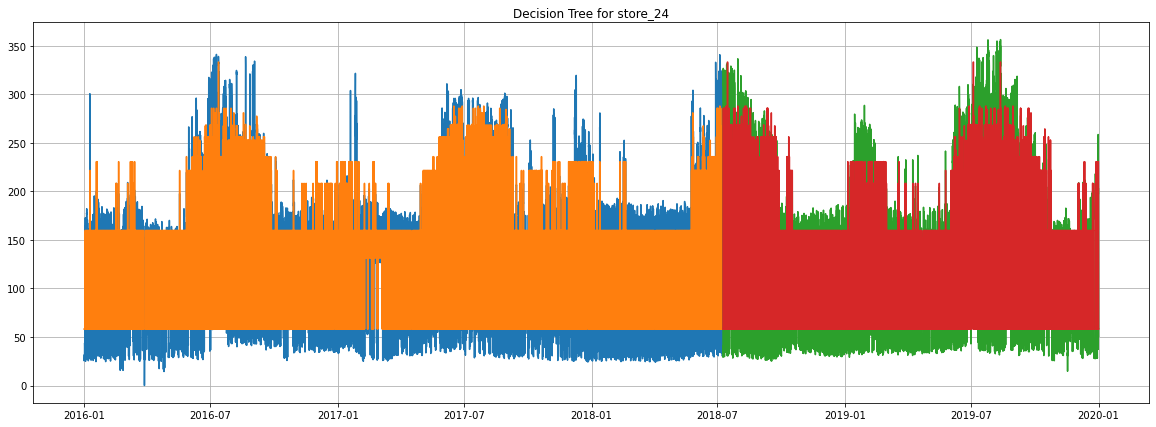

In [35]:
# Saving the plot
# in blue the kWh pre first intervention
# in orange the estimated kWh pre first intervention
# in greem the kWh post first intervention
# in red the estimated kWh post first intervention

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
ax.plot(y1)
ax.plot(pred)
plt.title('Decision Tree for {}'.format(città))
fig.savefig('DT_plot_ex.png')
plt.show()

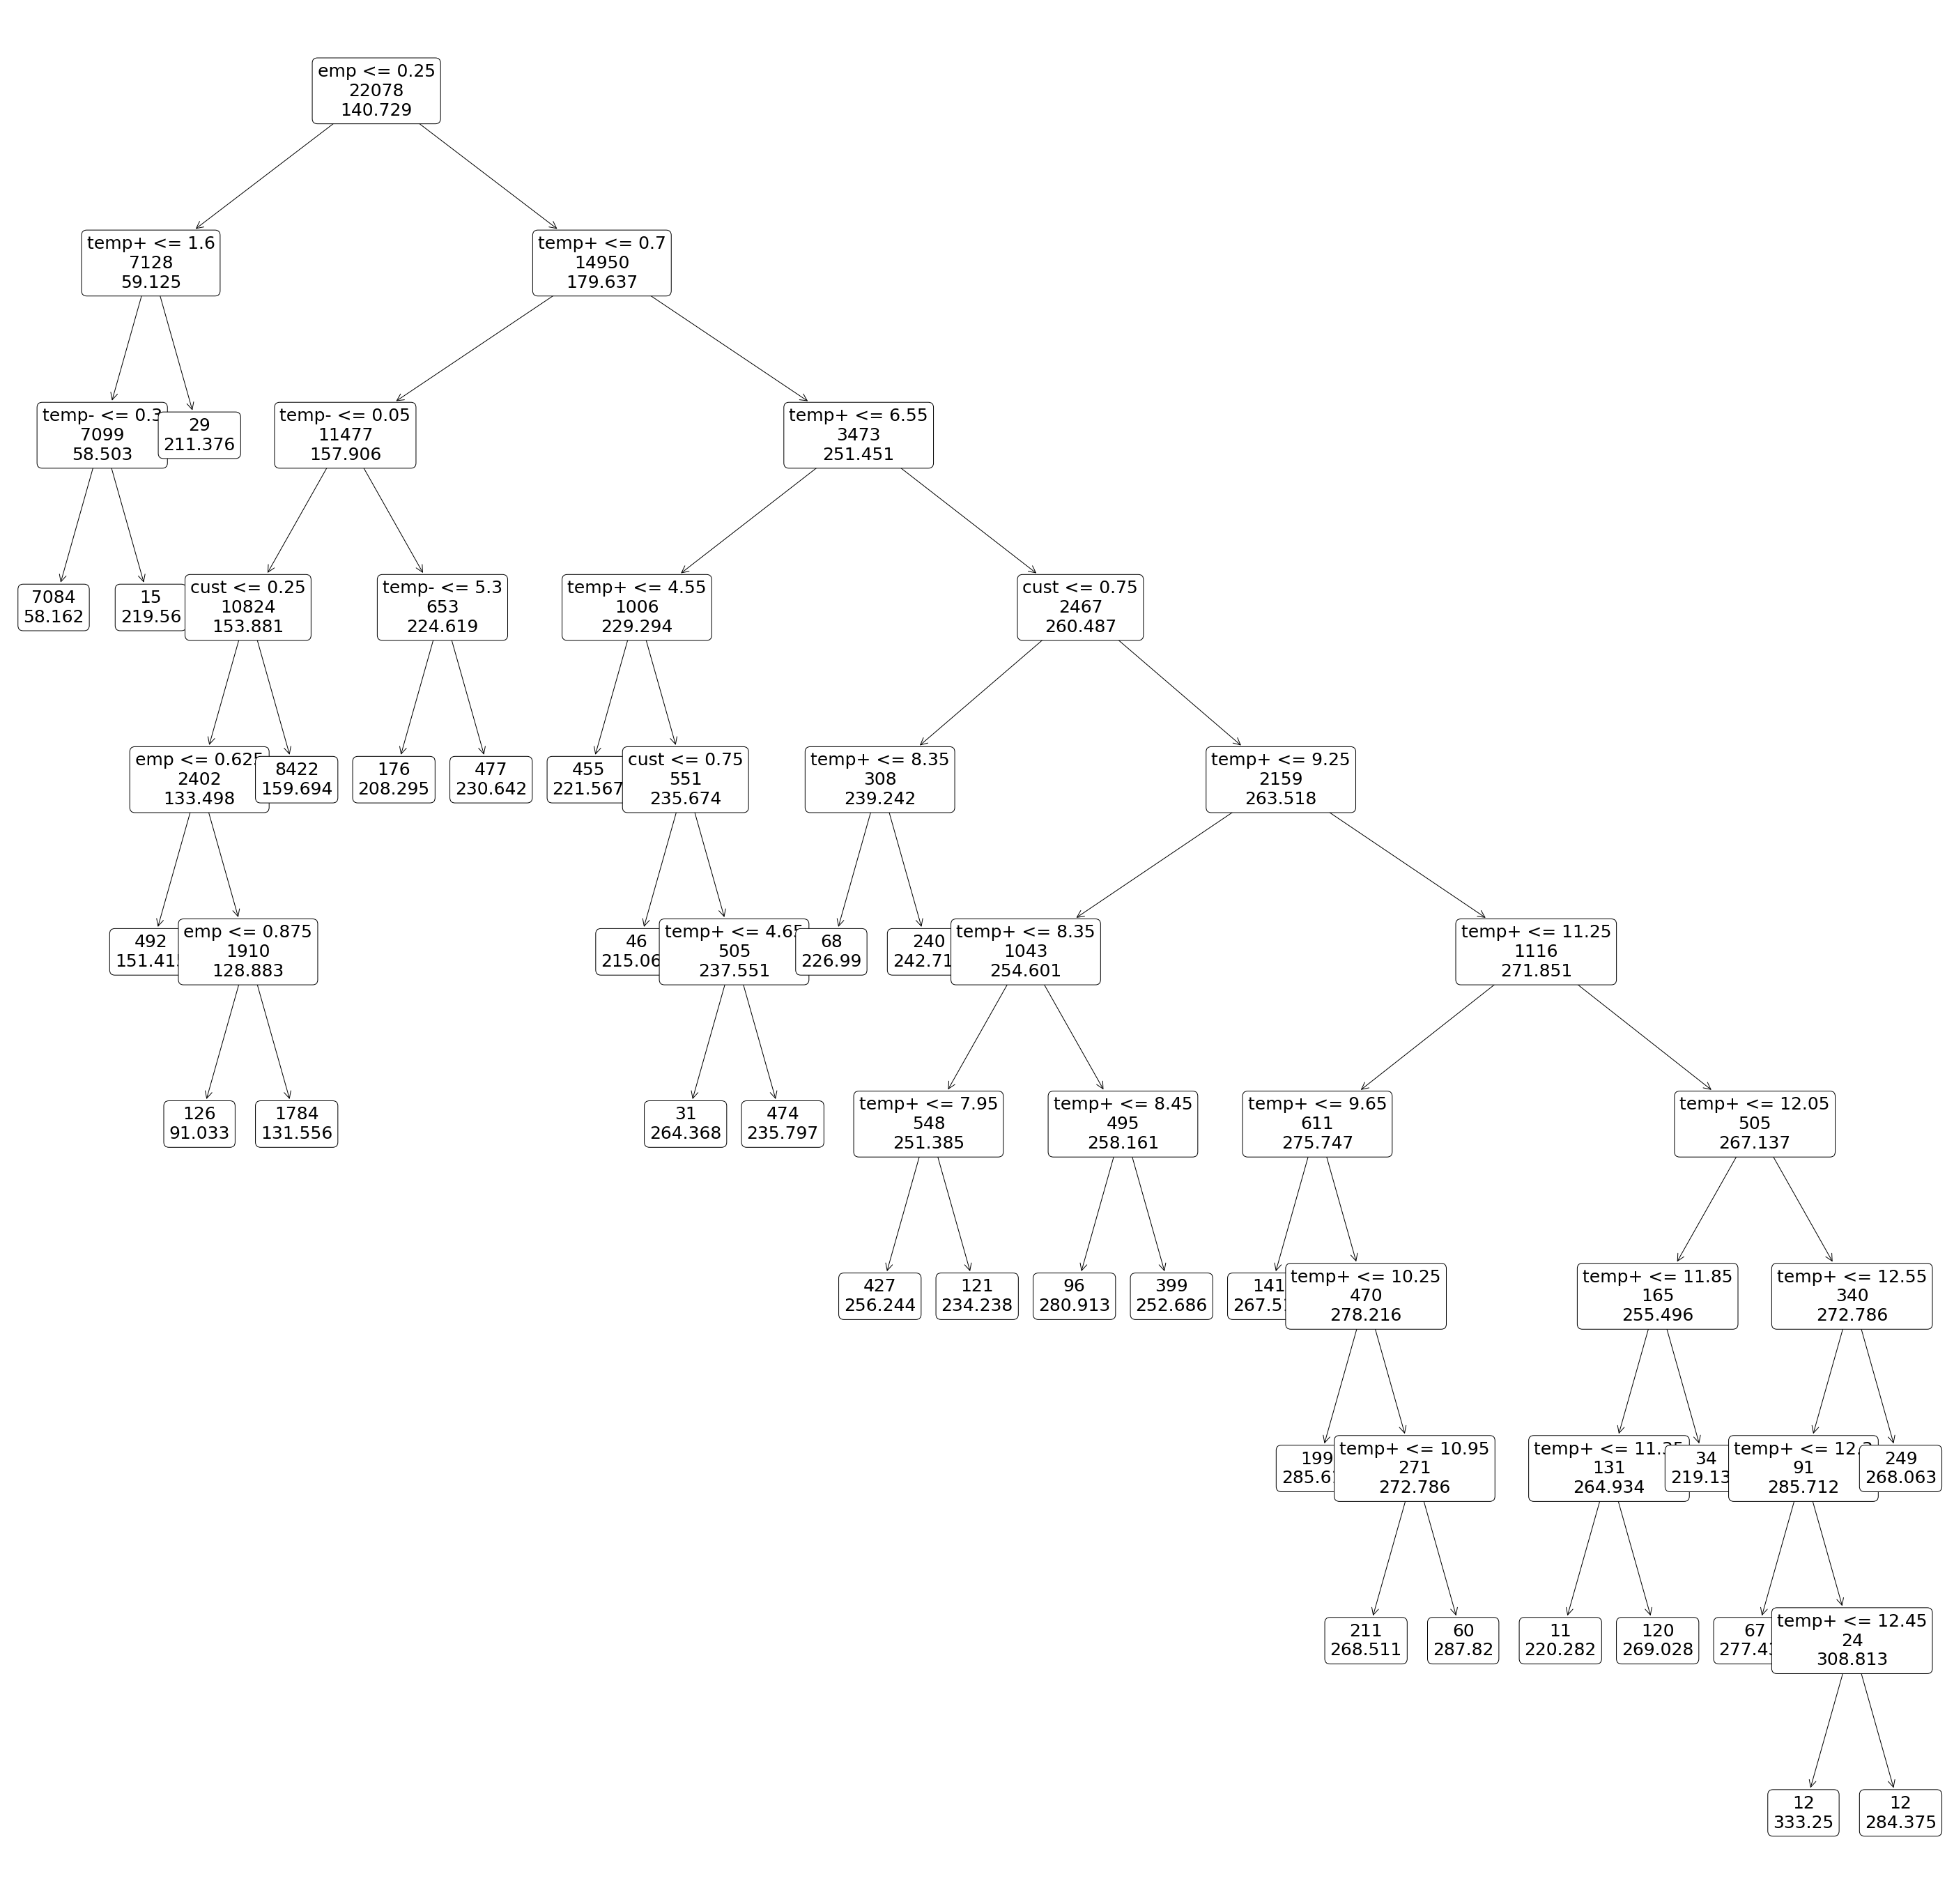

In [36]:
# Saving the tree

fig= plt.figure(figsize=(50,50))
plot_tree(model, feature_names=X, label='none', impurity=False, rounded=True, fontsize=25)
fig.savefig('DT_tree.png')
plt.show()

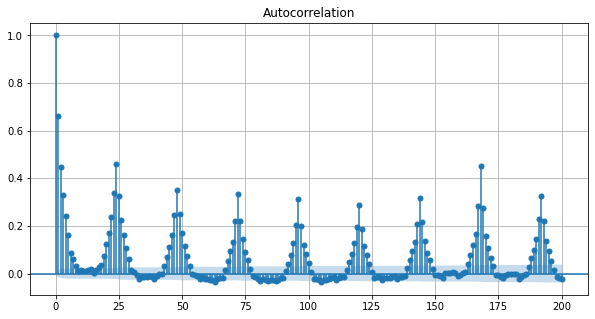

In [37]:
# Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('DT_acf.png')
plt.show()

In [38]:
# Again for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    # setting X
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    # finding index0
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    # 5-fold CV to select the maximum number of leaves
    max_leaf_nodes = range(20,51,5)
    parameters = {'max_leaf_nodes':max_leaf_nodes}
    clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)
    
    # building the model
    model = DecisionTreeRegressor(max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    #evaluating the results on the training set
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8806551501017987 776.4165836772338 0.8806551501017987


# Random Forest

In [39]:
# Setting X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []
for x in X:
    if len(data_edit[store].dropna()[x].unique()) > 1:
        X1.append(x)

# finding index0
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# 5-fold CV for the number of trees and the maximum number of leaves in each tree
n_estimators = range(1,52, 5)
max_leaf_nodes = range(20,51,5)
parameters = {'n_estimators':n_estimators, 'max_leaf_nodes':max_leaf_nodes}
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
clf.fit(X=x, y=y)
print(clf.best_params_)

# building the model thanks to the command again in sklearn
model = RandomForestRegressor(n_estimators = clf.best_params_['n_estimators'], max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

{'max_leaf_nodes': 20, 'n_estimators': 1}


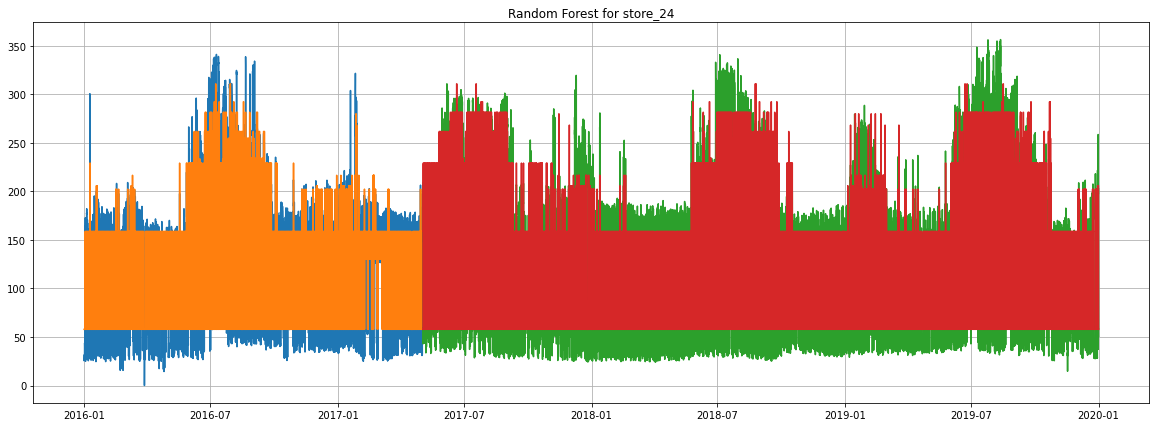

In [40]:
# Saving the plot
# colors as before

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
ax.plot(y1)
ax.plot(pred)
plt.title('Random Forest for {}'.format(città))
fig.savefig('RF_plot_ex.png')
plt.show()

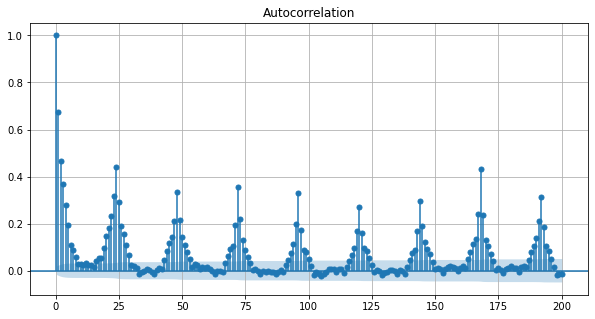

In [41]:
# Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('RF_acf.png')
plt.show()

In [42]:
# Again for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1: #data_edit['store_'].dropna()
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    n_estimators = range(1,52, 5)
    max_leaf_nodes = range(20,51,5)
    parameters = {'n_estimators':n_estimators, 'max_leaf_nodes':max_leaf_nodes}
    clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)

    model = RandomForestRegressor(n_estimators = clf.best_params_['n_estimators'], max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8813140663981546 771.2804527358415 0.8813145200654362


# K-Neighbors Regressor

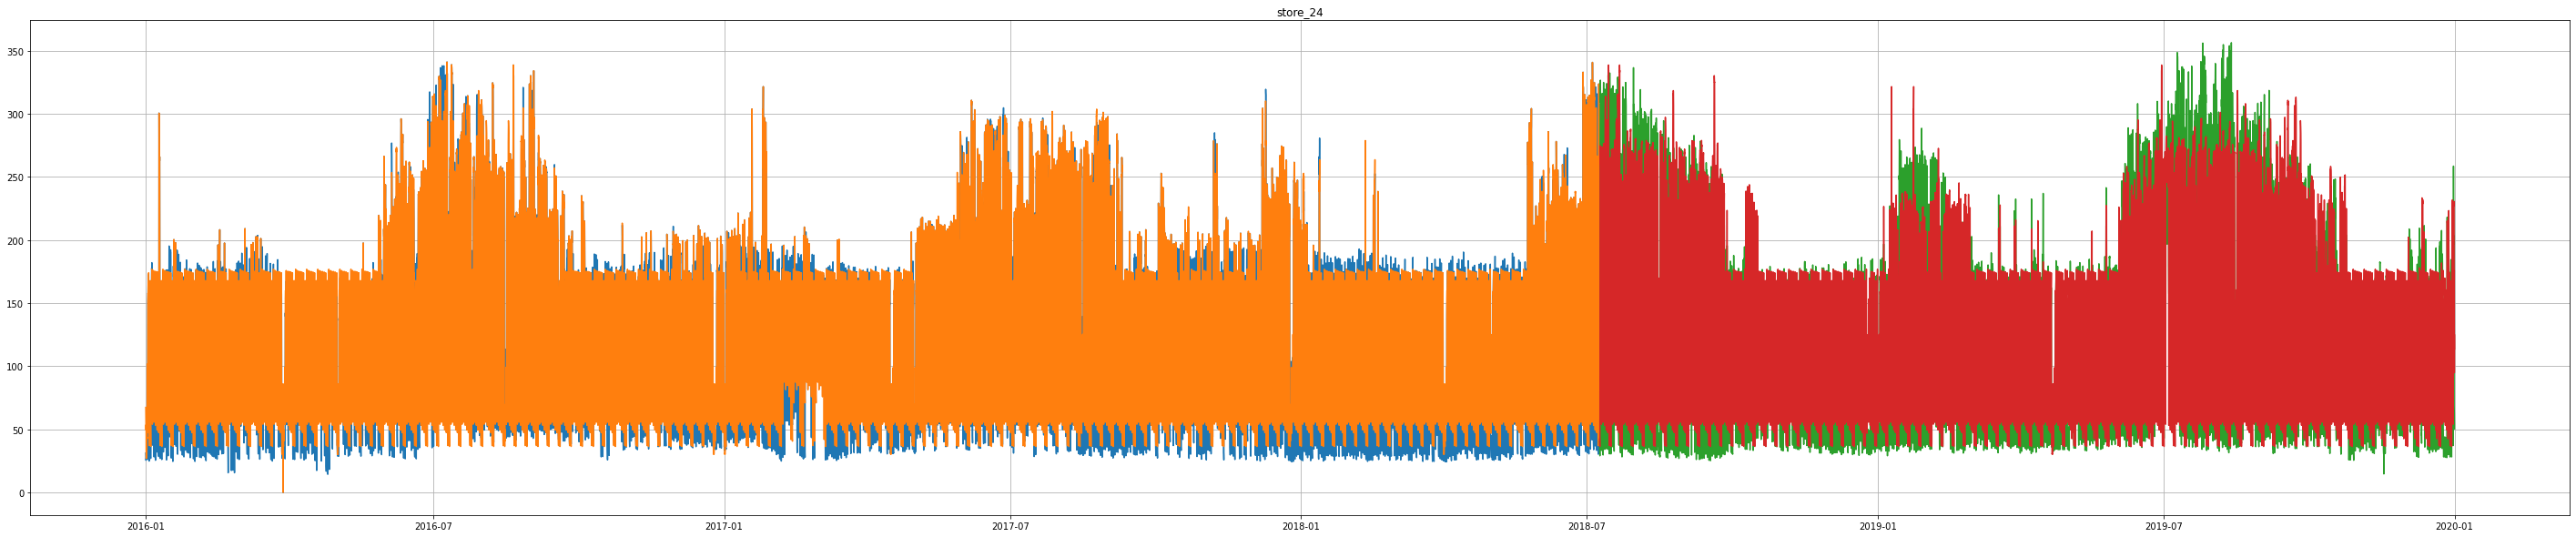

In [43]:
# set X
X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'w_day', 'hour']
X1 = []
for x in X:
    if len(data_edit[store].dropna()[x].unique()) > 1:
        X1.append(x)

# find index0
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# set x,x1,y,y1 as defined also before
# here we also add the dummies for w_day and hour
x = datacittà[datacittà.index<index0].dropna()[X1]
x = pd.get_dummies(x, prefix='w_day', columns=['w_day'])
x = pd.get_dummies(x, prefix='hour', columns=['hour'])
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
x1 = pd.get_dummies(x1, prefix='w_day', columns=['w_day'])
x1 = pd.get_dummies(x1, prefix='hour', columns=['hour'])
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# 5-fold CV to find the best value k for the closest neighbors to consider
n_neighbors = range(30,101,10)
parameters = {'n_neighbors':n_neighbors, 'weights':['distance']}
clf = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
clf.fit(X=x, y=y)

# fitting the kNN model
model = KNeighborsRegressor(clf.best_params_['n_neighbors'], weights = 'distance')
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)


# plotting the results
plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

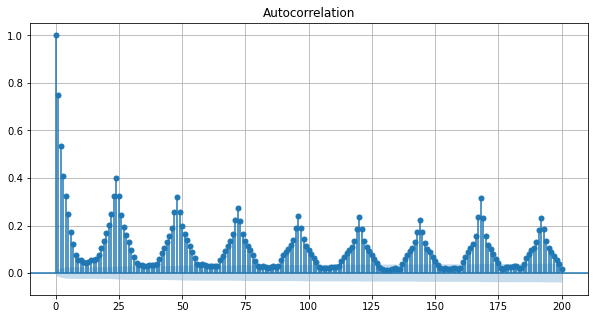

In [44]:
# Saving ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('kNN_acf.png')
plt.show()

In [45]:
# kNN for all the stores (without dummies)

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    n_neighbors = range(30,101,10)
    parameters = {'n_neighbors':n_neighbors, 'weights':['distance']}
    clf = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)

    model = KNeighborsRegressor(clf.best_params_['n_neighbors'], weights = 'distance')
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8630576950805949 862.1558901098231 0.8740950482459591


# AutoRegressive
Lag = 1, 2, 24, 7*24

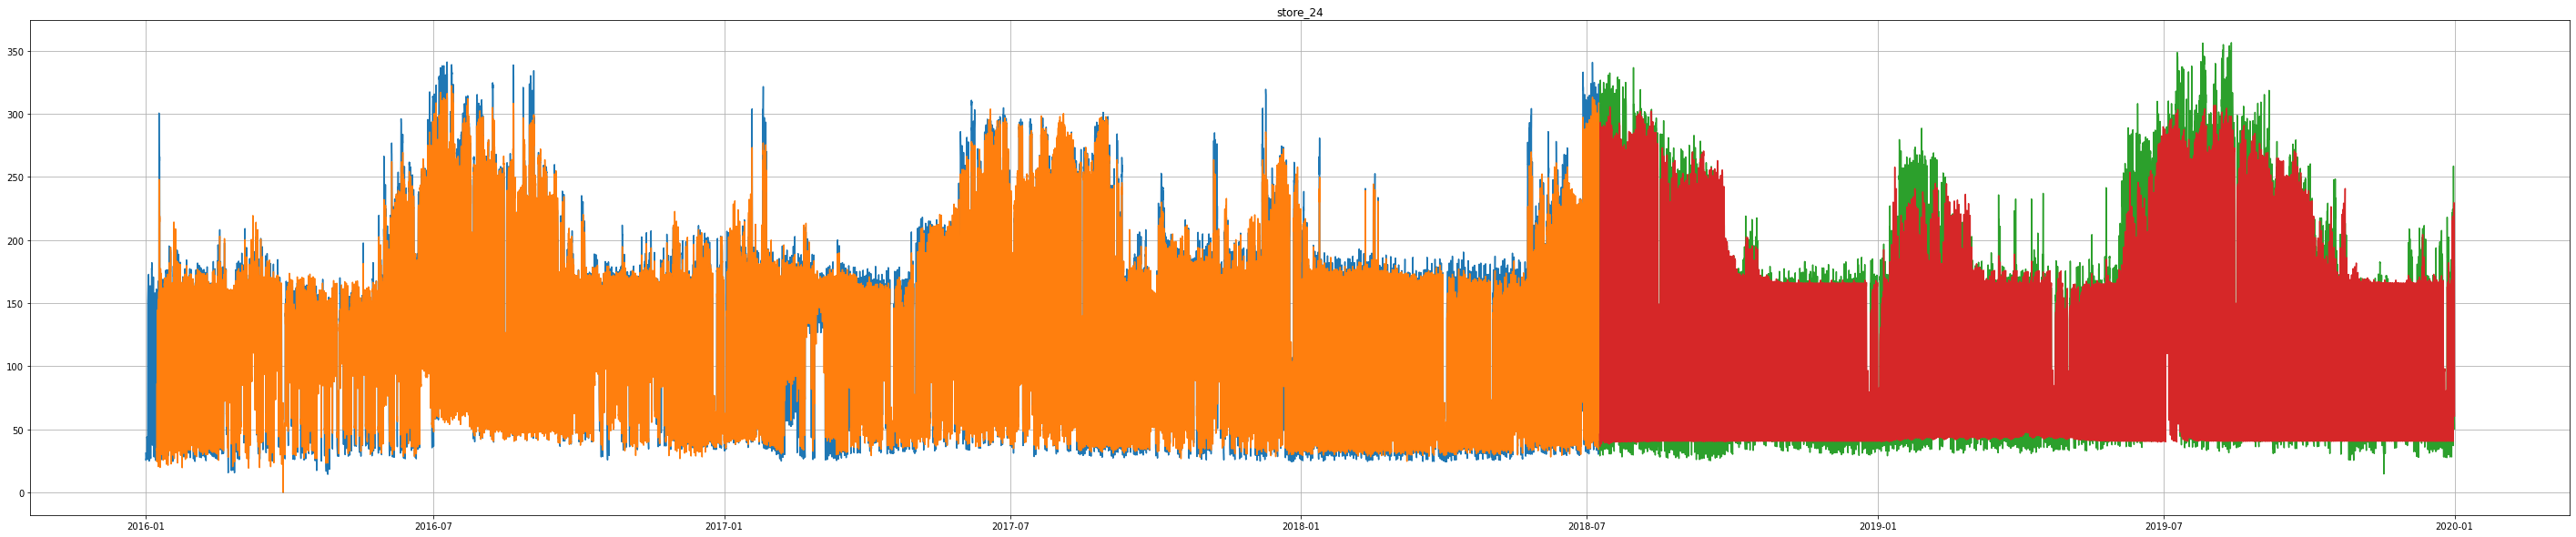

In [46]:
# set X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []

for x in X:
    if len(datacittà[x].unique()) > 1:
        X1.append(x)

# find index0
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# set model variables
# we don't need an intercept because it's already included in the AutoReg model
x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh'].values
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# fitting the model
model = AutoReg(y, [1, 2, 24, 7*24], exog=x)
results = model.fit()

# estimates
y=pd.Series(y)
y.index = x.index
yhat = results.fittedvalues
pred = results.predict(start = len(y), end = len(y)+x1.shape[0]-1, exog_oos = x1)
pred.index = y1.index


# plotting the results
plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

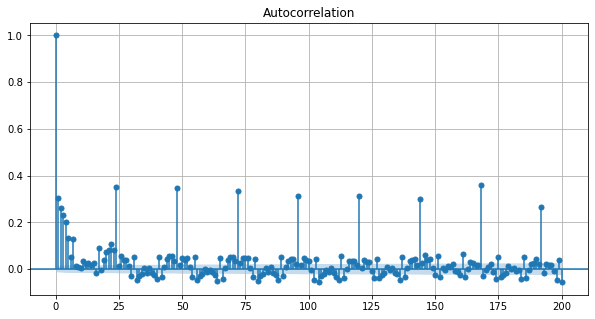

In [47]:
#Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(results.resid.dropna(), ax = ax, lags=200)
fig.savefig('AR_acf.png')
plt.show()

In [48]:
# AutoReg for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh'].values
    
    model = AutoReg(y, [1, 2, 24, 7*24], exog=x)
    results = model.fit()

    y=pd.Series(y)
    y.index = x.index
    yhat = results.fittedvalues
    y_true = y[168:]

    
    R2.append(r2_score(y_true, yhat))
    mse.append(mean_squared_error(y_true, yhat))
    expl_var.append(explained_variance_score(y_true, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.937370655303746 397.43417051369465 0.937370655303746


# Cahpter 3
# The State-Space Model
Here we show the code for the main section of the thesis

# The Kalman Filter

In [49]:
def Kfilter2(num,y,A,mu0,Sigma0,Phi,Ups,Gam,Theta,cQ,cR,S,u):
    cQ = np.asmatrix(cQ)
    Q = cQ.T.dot(cQ)
    cR = np.asmatrix(cR)
    R = cR.T.dot(cR)

    Phi = np.asmatrix(Phi)
    pdim = Phi.shape[0] 
    y = np.asmatrix(y).reshape((num,-1))
    qdim = y.shape[1]
    rdim = np.asmatrix(u).reshape((num,-1)).shape[1]
    Ups = np.asmatrix(Ups).T
    if (np.max(np.abs(Ups)) == 0):
        Ups = np.zeros((pdim,rdim))
    Gam = np.asmatrix(Gam)
    if (np.max(np.abs(Gam)) == 0):
        Gam = np.zeros((qdim,rdim))
    ut = np.asmatrix(u).reshape((num,rdim))
    xp = np.zeros((num,pdim,1)) # xp = x_t^{t-1}          
    Pp = np.zeros((num,pdim,pdim)) # Pp = P_t^{t-1}
    xf = np.zeros((num,pdim,1)) # xf = x_t^{t} 
    Pf = np.zeros((num,pdim,pdim)) # Pf = P_t^{t}
    Gain = np.zeros((num,pdim,qdim))
    innov = np.zeros((num,qdim,1)) # innovations
    sig = np.zeros((num,qdim,qdim)) # innov var-cov matrix
    like = 0                               # -log(likelihood)
    xp[:][:][0] = Phi.dot(mu0) + Ups.dot(ut[0])   # mu1
    Pp[:][:][0] = Phi.dot(Sigma0).dot(Phi.T)+Theta.dot(Q).dot(Theta.T)  #Sigma1
    #print(Pp[:][:][0])
    for i in range(num):
        B = np.asmatrix(A[i])
        innov[:][:][i] = y[i]-B.dot(xp[:][:][i])-Gam.dot(ut[i])
        sigma = B.dot(Pp[:][:][i]).dot(B.T)+R 
        sigma = (sigma.T+sigma)/2     # make sure sig is symmetric
        sig[:][:][i] = sigma
        siginv = np.linalg.inv(sigma)
        Gain[:][:][i] = (Phi.dot(Pp[:][:][i]).dot(B.T)+Theta.dot(S)).dot(siginv)
        K = np.asmatrix(Gain[:][:][i])
        xf[:][:][i] = xp[:][:][i] + Pp[:][:][i].dot(B.T).dot(siginv).dot(innov[:][:][i])
        Pf[:][:][i] = Pp[:][:][i] - Pp[:][:][i].dot(B.T).dot(siginv).dot(B).dot(Pp[:][:][i])

        like = like + np.float(np.log(np.linalg.det(sigma)) + innov[:][:][i].T.dot(siginv).dot(innov[:][:][i]))

        if i != (num-1):
            xp[:][:][i+1] = Phi.dot(xp[:][:][i]) + Ups.dot(ut[i+1,]) + K.dot(innov[:][:][i])
            Pp[:][:][i+1] = Phi.dot(Pp[:][:][i]).dot(Phi.T)+ Theta.dot(Q).dot(Theta.T) - K.dot(sig[:][:][i]).dot(K.T)
    	 
    like = 0.5*like
    return {'xp': xp,'Pp': Pp,'xf': xf,'Pf': Pf, 'K': Gain,'like': like,'innov': innov,'sig': sig}

# The Kalman Smoothing

In [50]:
def Ksmooth2(num,y,A,mu0,Sigma0,Phi,Ups,Gam,Theta,cQ,cR,S,u):
    kf = Kfilter2(num,y,A,mu0,Sigma0,Phi,Ups,Gam,Theta,cQ,cR,S,u)
    pdim = Phi.shape[0] 
    xs = np.zeros((num,pdim,1))
    Ps = np.zeros((num,pdim,pdim))
    J = np.zeros((num,pdim,pdim))
    xs[:][:][-1] = kf['xf'][:][:][-1]
    Ps[:][:][-1] = kf['Pf'][:][:][-1]
    for k in range(num-1, 0, -1):
        if np.linalg.det(kf['Pp'][:][:][k]) == 0:
            J[:][:][k-1] = (kf['Pf'][:][:][k-1].dot(Phi.T)).dot(np.linalg.inv(kf['Pp'][:][:][k]+np.diag(np.repeat(1e-100, len(kf['Pp'][:][:][k])))))
        else:
            J[:][:][k-1] = (kf['Pf'][:][:][k-1].dot(Phi.T)).dot(np.linalg.inv(kf['Pp'][:][:][k]))
        xs[:][:][k-1] = kf['xf'][:][:][k-1]+J[:][:][k-1].dot(xs[:][:][k]-kf['xp'][:][:][k])
        Ps[:][:][k-1] = kf['Pf'][:][:][k-1]+J[:][:][k-1].dot(Ps[:][:][k]-kf['Pp'][:][:][k]).dot(J[:][:][k-1].T)
    
    return {'xs': xs, 'Ps': Ps, 'xp': kf['xp'],'Pp': kf['Pp'], 'xf': kf['xf'],'Pf': kf['Pf'], 'like': kf['like'], 'Kn':kf['K']}

# The Monahan's reparameterisation

In [51]:
def Set_ARMA_parameters(vR, cp, cq):
    vPhi   = np.array(np.repeat(0, cp)).reshape((cp,1))
    vTheta = np.array(np.repeat(0, cq)).reshape((cq,1))
    
    if(cp>0):
        vRR = np.array(np.repeat(0, cp)).reshape((cp,1))
        for i in range(cp):
            vRR[i] = vR[i] / np.sqrt(1.0 + vR[i] * vR[i])
        vPhi[0] = vRR[0]
        for k in range(1,cp):
            vPhi[:k] = vPhi[:k] - vRR[k]*(vPhi[cp-k-1::-1])
            vPhi[k] = vRR[k]
    if(cq>0):
        vRR = np.array(np.repeat(0, cq)).reshape((cq,1))
        for i in range(cq):
            vRR[i] = vR[cp+i] / np.sqrt(1.0 + vR[cp+i] * vR[cp+i])
    vTheta[0] = vRR[0]
    for k in range(1,cq):
        vTheta[:k] = vTheta[:k] - vRR[k]*(vTheta[cq-k-1::-1])
        vTheta[k] = vRR[k]
        
    return(np.append(vPhi,vTheta))

# The SSF Model

In [52]:
# Define the log-likelyhood function to optimize

def Linn(para, y_data):
    num = len(y_data)
    alpha = para[0]
    phi1 = para[1]
    phi2 = para[2]
    theta1 = para[3]
    cQ1 = para[4]
    cR = para[5]
    
    ARMA_parameters = [phi1, phi2, theta1]
    ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
    phi1 = ARMA_parameters[0]
    phi2 = ARMA_parameters[1]
    theta1 = ARMA_parameters[2]
    
    Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
    for i in range(5):
        Phi_diag.append(1)
    Phi = np.diag(Phi_diag)
    Phi[1,0] = phi2
    Phi[0,1] = 1
    Phi[2,3] = np.sin(lambda1)
    Phi[3,2] = -np.sin(lambda1)
    Phi[4,5] = np.sin(lambda2)
    Phi[5,4] = -np.sin(lambda2)
    
    cQ = np.diag(np.repeat(cQ1, 11))
    
    Theta_diag = [1,theta1**2,1,0,1,0]
    for i in range(5):
        Theta_diag.append(1)
    Theta = np.diag(Theta_diag)
    Theta[0,1] = Theta[1,0] = theta1
    
    S = np.array(np.repeat(0,11)).reshape((11,1))
    mu0 = np.array(np.repeat(1,11)).reshape((11,1))
    Sigma0 = np.diag(np.repeat(1, 11))
    
    u = np.repeat(1, num).reshape(1,num,1)
    
    kf = Kfilter2(num,y_data,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)
    
    return(kf['like'])

In [53]:
# set X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []

for x in X:
    if len(datacittà[x].unique()) > 1:
        X1.append(x)

# find index0
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# set model variables
x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh'].values
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']


# set some of the matrices for the SSF
num = len(y)
A1 = np.array(np.repeat(1, num)).reshape((num,1))
A0 = np.array(np.repeat(0, num)).reshape((num,1))
Ax = x
A = np.hstack((A1,A0,A1,A0,A1,A0,Ax))
u = np.repeat(1, num).reshape(1,num,1)

lambda1 = (2*np.pi)/24
lambda2 = (2*np.pi)/168

# set the initial values for the parameters to optimize
init_par = [-.77, .84, .83, .85, .12, 1.1]

# find the best values for the parameters, remembering to correct the ARMA ones
est = minimize(Linn, init_par, args=y, hess=True, options ={'maxiter':3})

alpha = est.x[0]
phi1 = est.x[1]
phi2 = est.x[2]
theta1 = est.x[3]
cQ1 = est.x[4]
cR = est.x[5]

ARMA_parameters = [phi1, phi2, theta1]
ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
phi1 = ARMA_parameters[0]
phi2 = ARMA_parameters[1]
theta1 = ARMA_parameters[2]


# set the remaining SSF matrices with the values just found through optimization
Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
for i in range(5):
    Phi_diag.append(1)
Phi = np.diag(Phi_diag)
Phi[1,0] = phi2
Phi[0,1] = 1
Phi[2,3] = np.sin(lambda1)
Phi[3,2] = -np.sin(lambda1)
Phi[4,5] = np.sin(lambda2)
Phi[5,4] = -np.sin(lambda2)

cQ = np.diag(np.repeat(cQ1, 11))

Theta_diag = [1,theta1**2,1,0,1,0]
for i in range(5):
    Theta_diag.append(1)
Theta = np.diag(Theta_diag)
Theta[0,1] = Theta[1,0] = theta1

S = np.array(np.repeat(0,11)).reshape((11,1))
mu0 = np.array(np.repeat(1,11)).reshape((11,1))
Sigma0 = np.diag(np.repeat(1, 11))


# fitting the model with the Kalman Filter
kf = Kfilter2(num,y,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)

# fitting the model with the Kalman Smoothing
ks = Ksmooth2(num,y,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)

# setting again y to have an index
y = pd.Series(y)
y.index = x.index

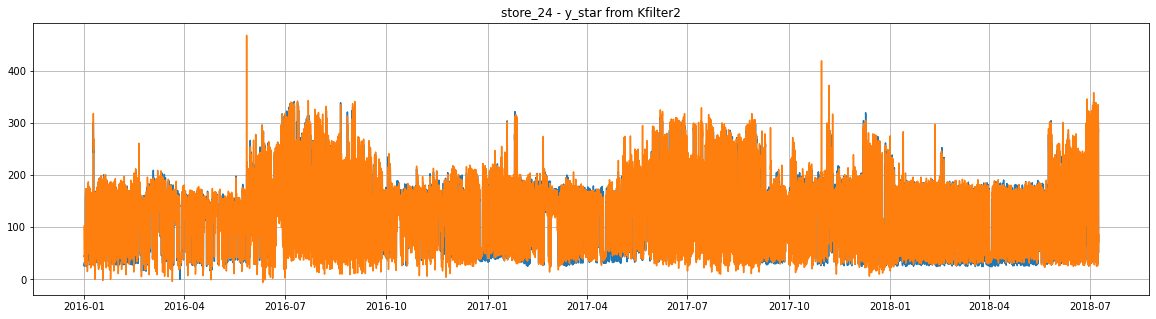

In [54]:
# finging the estimates of the KF
y_star_f = np.repeat(0, num)
for i in range(num):
    if np.isnan(kf['xp'][i][0]):
        y_star_f[i] = 0
    else:
        y_star_f[i] = A[i].dot(kf['xp'][i])+alpha

y_star_f = pd.Series(y_star_f)
y_star_f.index = y.index


# saving the plot
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(y_star_f)
plt.title('{} - y_star from Kfilter2'.format(città))
fig.savefig('SSM_kf_plot.png')
plt.show()

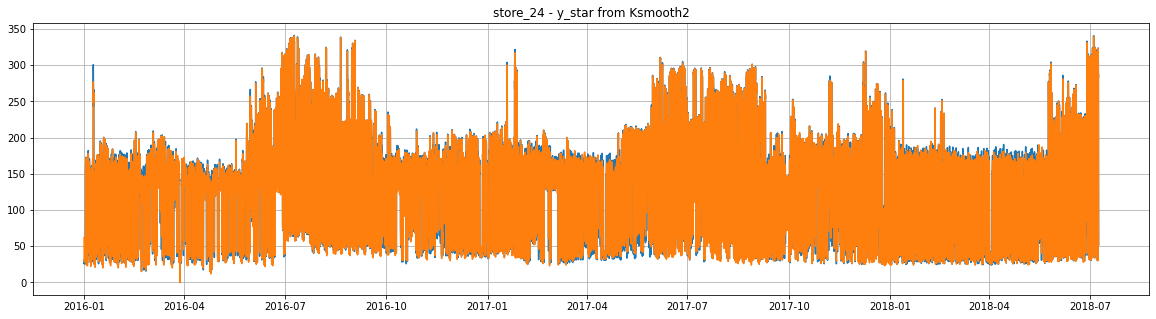

In [55]:
# finging the estimates of the KS
y_star_s = np.repeat(0, num)
for i in range(num):
    y_star_s[i] = A[i].dot(ks['xs'][i])+alpha

y_star_s = pd.Series(y_star_s)
y_star_s.index = y.index

# saving the plot
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(y_star_s)
plt.title('{} - y_star from Ksmooth2'.format(città))
fig.savefig('SSM_ks_plot.png')
plt.show()

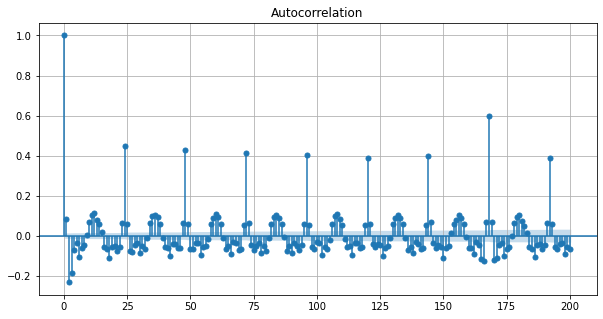

In [56]:
# Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-y_star_s, ax = ax, lags=200)
fig.savefig('SSM_acf.png')
plt.show()

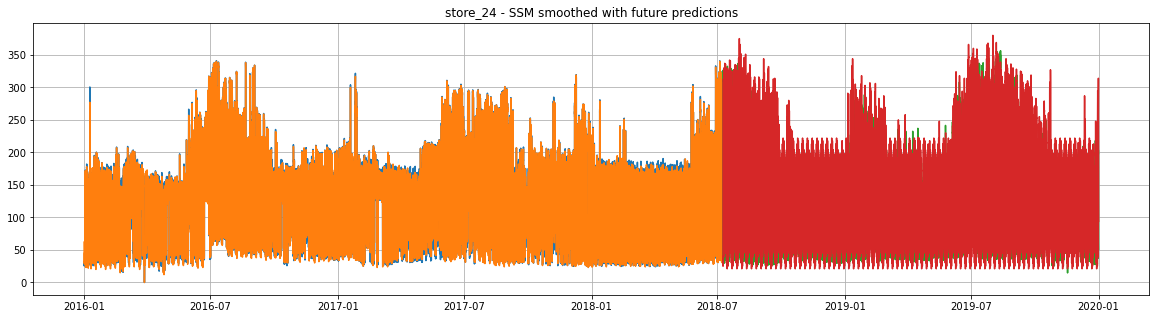

In [57]:
# estimating y1 with KS

y1_star_s = np.repeat(0, len(y1))
xs_star_s = []

for i,x1_i in enumerate(x1.values):
    if i == 0:
        xs_star_s.append(Phi.dot(ks['xs'][-1]))
    else:
        xs_star_s.append(Phi.dot(np.array(xs_star_s[-1])))
    A_i = np.array([1,0,1,0,1,0]+list(x1_i))
    y1_star_s[i] = A_i.dot(xs_star_s[i])+alpha

y1_star_s = pd.Series(y1_star_s)
y1_star_s.index = y1.index
xs_star_s = np.array(xs_star_s)

# saving the plot
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(y_star_s)
ax.plot(y1)
ax.plot(y1_star_s)
plt.title('{} - SSM smoothed with future predictions'.format(città))
fig.savefig('SSM_ks_plot_wp.png')
plt.show()

Now we collect the results for all the stores, with the same model we used just above

In [58]:
# defining a function that includes most of the steps to get the estimates of the model

def SSM_complete(y,x):
    # setting some SSF matrices
    num = len(y)
    A1 = np.array(np.repeat(1, num)).reshape((num,1))
    A0 = np.array(np.repeat(0, num)).reshape((num,1))
    Ax = x
    A = np.hstack((A1,A0,A1,A0,A1,A0,Ax))
    u = np.repeat(1, num).reshape(1,num,1)

    lambda1 = (2*np.pi)/24
    lambda2 = (2*np.pi)/168
    
    
    ############################################################################################
    # redefining the log-likelyhood function at each repetion
    def Linn(para, y_data):
        alpha = para[0]
        phi1 = para[1]
        phi2 = para[2]
        theta1 = para[3]
        cQ1 = para[4]
        cR = para[5]

        ARMA_parameters = [phi1, phi2, theta1]
        ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
        phi1 = ARMA_parameters[0]
        phi2 = ARMA_parameters[1]
        theta1 = ARMA_parameters[2]

        Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
        for i in range(5):
            Phi_diag.append(1)
        Phi = np.diag(Phi_diag)
        Phi[1,0] = phi2
        Phi[0,1] = 1
        Phi[2,3] = np.sin(lambda1)
        Phi[3,2] = -np.sin(lambda1)
        Phi[4,5] = np.sin(lambda2)
        Phi[5,4] = -np.sin(lambda2)

        cQ = np.diag(np.repeat(cQ1, 11))

        Theta_diag = [1,theta1**2,1,0,1,0]
        for i in range(5):
            Theta_diag.append(1)
        Theta = np.diag(Theta_diag)
        Theta[0,1] = Theta[1,0] = theta1

        S = np.array(np.repeat(0,11)).reshape((11,1))
        mu0 = np.array(np.repeat(1,11)).reshape((11,1))
        Sigma0 = np.diag(np.repeat(1, 11))

        kf = Kfilter2(num,y_data,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)

        return(kf['like'])

    ############################################################################################# 
    
    
    
    
    # setting the initial values for the parameters and optimize them
    init_par = [-.77, .84, .83, .85, .12, 1.1]
    est = minimize(Linn, init_par, args=y, options ={'maxiter':3})

    alpha = est.x[0]
    phi1 = est.x[1]
    phi2 = est.x[2]
    theta1 = est.x[3]
    cQ1 = est.x[4]
    cR = est.x[5]

    ARMA_parameters = [phi1, phi2, theta1]
    ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
    phi1 = ARMA_parameters[0]
    phi2 = ARMA_parameters[1]
    theta1 = ARMA_parameters[2]
    
    # setting the remaining SSF matrices with the optimized parameters
    Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
    for i in range(5):
        Phi_diag.append(1)
    Phi = np.diag(Phi_diag)
    Phi[1,0] = phi2
    Phi[0,1] = 1
    Phi[2,3] = np.sin(lambda1)
    Phi[3,2] = -np.sin(lambda1)
    Phi[4,5] = np.sin(lambda2)
    Phi[5,4] = -np.sin(lambda2)

    cQ = np.diag(np.repeat(cQ1, 11))

    Theta_diag = [1,theta1**2,1,0,1,0]
    for i in range(5):
        Theta_diag.append(1)
    Theta = np.diag(Theta_diag)
    Theta[0,1] = Theta[1,0] = theta1

    S = np.array(np.repeat(0,11)).reshape((11,1))
    mu0 = np.array(np.repeat(1,11)).reshape((11,1))
    Sigma0 = np.diag(np.repeat(1, 11))
    
    # fitting the KS and computing the estimates
    ks = Ksmooth2(num,y,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)
    
    y_star_s = np.repeat(0, num)
    for i in range(num):
        y_star_s[i] = A[i].dot(ks['xs'][i])+alpha

    y_star_s = pd.Series(y_star_s)
    y_star_s.index = y.index
    
    # returning the estimates
    return y_star_s

In [59]:
R2 = []
mse = []
expl_var = []

for store in data_edit:
    # here we use X1 equals for all the stores, since it would be hard to change the log-likelyhood function for each different X1
    X1 = ['error', 'cust', 'emp', 'temp+', 'temp-']
    
    # finding index0
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    # setting the variables for the SSF model
    x = data_edit[store][data_edit[store].index<index0].dropna()[X1].values
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    # usinig the previous function to compute the estimates
    results = SSM_complete(y,x)
    yhat = results
    y_true = y
    
    #evaluating the results
    R2.append(r2_score(y_true, yhat))
    mse.append(mean_squared_error(y_true, yhat))
    expl_var.append(explained_variance_score(y_true, yhat))
    
print(np.median(expl_var), np.median(mse))

0.9434414200708393 182.61128429918324


We now see the results inserted in Table 3.2.
The model used here works with the interventions variables inserted in the regression part of the model (so without training/test sets)

In [60]:
# defining a function that includes most of the steps to get the state vectors' values

def SSM_xs(y,x):
    # setting some of the SSF matrices
    m= len(x[0])
    num = len(y)
    A1 = np.array(np.repeat(1, num)).reshape((num,1))
    A0 = np.array(np.repeat(0, num)).reshape((num,1))
    Ax = x
    A = np.hstack((A1,A0,A1,A0,A1,A0,Ax))
    u = np.repeat(1, num).reshape(1,num,1)

    lambda1 = (2*np.pi)/24
    lambda2 = (2*np.pi)/168
    
    
    ############################################################################################
    # redefining the log-likelyhood function at each repetion
    def Linn(para, y_data):
        alpha = para[0]
        phi1 = para[1]
        phi2 = para[2]
        theta1 = para[3]
        cQ1 = para[4]
        cR = para[5]

        ARMA_parameters = [phi1, phi2, theta1]
        ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
        phi1 = ARMA_parameters[0]
        phi2 = ARMA_parameters[1]
        theta1 = ARMA_parameters[2]

        Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
        for i in range(m):
            Phi_diag.append(1)
        Phi = np.diag(Phi_diag)
        Phi[1,0] = phi2
        Phi[0,1] = 1
        Phi[2,3] = np.sin(lambda1)
        Phi[3,2] = -np.sin(lambda1)
        Phi[4,5] = np.sin(lambda2)
        Phi[5,4] = -np.sin(lambda2)

        cQ = np.diag(np.repeat(cQ1, 6+m))

        Theta_diag = [1,theta1**2,1,0,1,0]
        for i in range(m):
            Theta_diag.append(1)
        Theta = np.diag(Theta_diag)
        Theta[0,1] = Theta[1,0] = theta1

        S = np.array(np.repeat(0,6+m)).reshape((6+m,1))
        mu0 = np.array(np.repeat(1,6+m)).reshape((6+m,1))
        Sigma0 = np.diag(np.repeat(1, 6+m))

        kf = Kfilter2(num,y_data,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)

        return(kf['like'])

    ############################################################################################# 
    
    
    
    
    # setting the initial values for the parameters and optimize them
    init_par = [-.77, .84, .83, .85, .12, 1.1]
    est = minimize(Linn, init_par, args=y, options ={'maxiter':3})

    alpha = est.x[0]
    phi1 = est.x[1]
    phi2 = est.x[2]
    theta1 = est.x[3]
    cQ1 = est.x[4]
    cR = est.x[5]

    ARMA_parameters = [phi1, phi2, theta1]
    ARMA_parameters = Set_ARMA_parameters(ARMA_parameters,2,1)
    phi1 = ARMA_parameters[0]
    phi2 = ARMA_parameters[1]
    theta1 = ARMA_parameters[2]
    
    # setting the remaining SSF matrices with the optimized parameters
    Phi_diag = [phi1,0,np.cos(lambda1),np.cos(lambda1),np.cos(lambda2),np.cos(lambda2)]
    for i in range(m):
        Phi_diag.append(1)
    Phi = np.diag(Phi_diag)
    Phi[1,0] = phi2
    Phi[0,1] = 1
    Phi[2,3] = np.sin(lambda1)
    Phi[3,2] = -np.sin(lambda1)
    Phi[4,5] = np.sin(lambda2)
    Phi[5,4] = -np.sin(lambda2)

    cQ = np.diag(np.repeat(cQ1, 6+m))

    Theta_diag = [1,theta1**2,1,0,1,0]
    for i in range(m):
        Theta_diag.append(1)
    Theta = np.diag(Theta_diag)
    Theta[0,1] = Theta[1,0] = theta1

    S = np.array(np.repeat(0,6+m)).reshape((6+m,1))
    mu0 = np.array(np.repeat(1,6+m)).reshape((6+m,1))
    Sigma0 = np.diag(np.repeat(1, 6+m))
    
    # fitting the KS
    kf = Kfilter2(num,y,A,mu0,Sigma0,Phi,0,alpha,Theta,cQ,cR,S,u)
    
    # returning the state variables
    return kf['xf']

In [61]:
# it's a very time consuming operation, so we check how much time does it take
start_time = time.time()

for store in data_edit:
    # printing the store we are now considering
    print(store)
    
    # again we check for the time
    start_time_i = time.time()
    
    # setting X1 for the model and X2 for just the intervention(s) in the model
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    X2 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
            if x in ['led', 'pvp', 'BMS']:
                X2.append(x)
    
    # finding index0 for each intervention
    index0_led = datetime.datetime(2020, 1, 1)
    if len(data_edit[store].dropna()['led'].unique()) > 1:
        if index0_led > data_edit[store][data_edit[store]['led']==1].index[0]:
            index0_led = data_edit[store][data_edit[store]['led']==1].index[0]
            
    index0_pvp = datetime.datetime(2020, 1, 1)
    if len(data_edit[store].dropna()['pvp'].unique()) > 1:
        if index0_pvp > data_edit[store][data_edit[store]['pvp']==1].index[0]:
            index0_pvp = data_edit[store][data_edit[store]['pvp']==1].index[0]
            
    index0_BMS = datetime.datetime(2020, 1, 1)
    if len(data_edit[store].dropna()['BMS'].unique()) > 1:
        if index0_BMS > data_edit[store][data_edit[store]['BMS']==1].index[0]:
            index0_BMS = data_edit[store][data_edit[store]['BMS']==1].index[0]
            
    
    # if we have no intervention the model is not even fitted, otherwise we fit the model and print the results
    if len(X2)>0:
        x = data_edit[store].dropna()[X1].values
        y = data_edit[store].dropna()['kWh']

        
        # finding the estimates with the function defined just above and putting them in a DataFrame (instead of an array)
        results = SSM_xs(y,x)
        results = pd.DataFrame(results.squeeze(), index = y.index, columns = ['AR_1', 'AR_0', 'S1_1', 'S1_0', 'S2_1', 'S2_0']+X1)
        
        
        # if an intervention happened, print the median and the mean of the relative state vector values for both pre and post intervention
        if index0_led< datetime.datetime(2020, 1, 1):
            print('\n\nled\n')
            print('median pre-interventions', np.median(results[results.index<index0_led]['led']))
            print('mean pre-interventions', np.mean(results[results.index<index0_led]['led']))
        
            print('median post-interventions', np.median(results[results.index>=index0_led]['led']))
            print('mean post-interventions', np.mean(results[results.index>=index0_led]['led']))
        
        if index0_pvp< datetime.datetime(2020, 1, 1):
            print('\npvp\n')
            print('median pre-interventions', np.median(results[results.index<index0_pvp]['pvp']))
            print('mean pre-interventions', np.mean(results[results.index<index0_pvp]['pvp']))
        
            print('median post-interventions', np.median(results[results.index>=index0_pvp]['pvp']))
            print('mean post-interventions', np.mean(results[results.index>=index0_pvp]['pvp']))
            
        if index0_BMS< datetime.datetime(2020, 1, 1):
            print('\nBMS\n')
            print('median pre-interventions', np.median(results[results.index<index0_BMS]['BMS']))
            print('mean pre-interventions', np.mean(results[results.index<index0_BMS]['BMS']))
        
            print('median post-interventions', np.median(results[results.index>=index0_BMS]['BMS']))
            print('mean post-interventions', np.mean(results[results.index>=index0_BMS]['BMS']))
        

    print('\n')
    
    # compute the time for each fitted model
    end_time_i = time.time()
    print("Modello {} in {} minuti.\n\n\n ".format(store, int((end_time_i-start_time_i)/60+1)))
    
    
# compute the time for fitting all the models
end_time = time.time()
print("Tutti i modelli in {} minuti.\n ".format(int((end_time-start_time)/60+1)))

store_1


Modello store_1 in 1 minuti.


 
store_2

BMS

median pre-interventions 1.0
mean pre-interventions 1.0
median post-interventions 13.367498749016933
mean post-interventions 15.093800350519423


Modello store_2 in 6 minuti.


 
store_3


led

median pre-interventions 1.0
mean pre-interventions -0.06840248363082933
median post-interventions 16.763023464944247
mean post-interventions 18.983162686880526

BMS

median pre-interventions 1.0
mean pre-interventions 1.0
median post-interventions -1100.711312034136
mean post-interventions -1087.233371905308


Modello store_3 in 13 minuti.


 
store_4


Modello store_4 in 1 minuti.


 
store_5


led

median pre-interventions 1.0
mean pre-interventions 0.8683450290889971
median post-interventions 19.0502779662298
mean post-interventions 20.852555124448447

BMS

median pre-interventions 1.0
mean pre-interventions 1.0
median post-interventions -363.70063996917105
mean post-interventions -355.1410739236156


Modello store_5 in 11 minuti.


 
